In [29]:
%matplotlib inline
import deepdish as dd
import h5py
import numpy as np
from galaxy_analysis.plot.plot_styles import *
import matplotlib.pyplot as plt
from galaxy_analysis.utilities import utilities
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from galaxy_analysis.utilities import convert_abundances

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import glob
import os, sys


def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()

from matplotlib.text import TextPath

yr_s = 3.154E7



#sys.stdout = TracePrints()

In [30]:
def dlist_asarray(dict_list, key_list, as_list = False):
    
    res = [None]*len(dict_list)
    #print(len(dict_list))
    
    for i,d in enumerate(dict_list):
        res[i] = extract_nested_dict(d, key_list)
        
    if as_list:
        return res
    
    return np.array(res)
 

    
def extract_nested_dict(dict, key_list):
    """
    Given a list of kwargs, extracts the information requested
    from a nested dictionary
    """
    x = dict

    if isinstance(key_list, str) or isinstance(key_list, tuple):
        x = x[key_list]
    elif isinstance(key_list, list):
        for k in key_list:
            x = x[k]

    return x


    
#def extract_nested_dict(d, key_list):
#    
#    if isinstance(key_list, str):
#        return d[key_list]
#    elif len(key_list) == 1:
#        try:
#            return d[key_list[0]]
##        except:
 #           print(key_list)
#            print(key_list[0])
#            print(d)
#            raise ValueError
#    
#    return extract_nested_dict( d[key_list[0]], key_list[1:])

class DataContainer:
    
    def __init__(self, directory, file_list = None, self_contained = False,
                 name = None, data_file_name = "*_galaxy_data.h5"):
        
        self.directory = directory
        
        self.self_contained = self_contained # sets if the "file list" is a list
                                             # files to be loaded (False) or 
                                             # a list of data dump names (True)
                                             # contained within the data_file_name
        
        self.file_list      = file_list
        self.data_file_name = data_file_name

        self._data = {} # stores data
        
        if (self.file_list is None):
            
            if not self.self_contained:
                self.file_list = np.sort(glob.glob(directory + '/' + self.data_file_name))
            else:
                raise NotImplementedError 
      
    
        self.known_paths = {'SFR'  : '/time_data/SFR',
                            'time' : '/meta_data/Time',
                            'meta_data' : '/meta_data',
                           }
        self.load_phase_plots()        
        
        
        if name is None:
            self.name = directory
        else:
            self.name = name
            
        self.load_loading_table()
            
            
        # do some prep
        self.load_field(self.known_paths['time'],label='time',
                        reload=True, to_array=True)
        
        self.t_sf_start = self.data('time')[0]
        self.first_DD   = int(self.t_sf_start)
        
        self.load_field(self.known_paths['meta_data'], label='meta_data',
                        reload=True, to_array=False)
                
        # pre-load the easy things
        for k in self._data['meta_data'][0].keys():
            self._data[k] = dlist_asarray( self._data['meta_data'], [k])
    
        return
        
    def data(self, label):
        
        if label in self.loaded_fields():
            return self._data[label]
        
        if label in self.known_paths:
            path = self.known_paths[label]
        
        self.load_field(path, label=label)
        
        return self._data[label]
    
    
    def load_loading_table(self):
        # load (if available) loading table from LiBryan2019 
        
        loading_table = glob.glob( self.directory + '/*loading_table.dat')
        
        if len(loading_table) == 0:
            self.loading_table_values = None
            print("Loading data table not found for ", self.name)
            return
        
        
        keys = ["Eta_mass", "Eta_mass_hot", "Eta_mass_cold", 
                "Eta_metal", "Eta_metal_hot", "Eta_metal_cold", 
                "Eta_E", "Eta_E_hot", "Eta_E_cold", "Eta_E_hot_cold_ratio",
                "e_s", "e_s_hot", "e_s_cold", "e_s_hot_cold_ratio",
                "Sigma_gas", "Sigma_sfr", "Eta_hot_Eta_Metal_hot_ratio"]
        
        self.loading_table_values = {}
        for k in keys:
            self.loading_table_values[k] = -999
            
        with open(loading_table[0]) as fp:
            count = 0
            for line in fp:
                self.loading_table_values[ keys[count] ] = float(line.split(" ")[-1])
                count = count + 1
    
        return
            
    
    def load_single(self, path, filename = None, index = None):
        
        if (filename is None) and (index is None):
            print("Must provide either name of file or index in file_list")
            raise ValueError
            
        if (filename is None):
            filename = self.file_list[index]
            
        if path in self.known_paths.keys(): # assume path = label if true
            path = self.known_paths[path]
                
        
        return dd.io.load(filename, path)
        
        
    def load_field(self, path, label = None, reload = False,
                               to_array    = True):
        """
        Grab data from file given dictionary path. 
        
        path   :  str
            string or list of strings to pass to deepdish
            to selectively load the desired field. 
        label  : str, optional
            optional alias to be used in place of path
            in self.data dictionary. Default: none (set to path)
        reload  : bool, optional
            By default, just returns data in self.data if 
            label exists already. Otherwise reloads and overwrites.
            Default : False
        to_array: bool, optional
            By default, if retrieved data are just single scalars
            it is stored as a numpy array. Otherwise it is kept 
            as a list. Set this to override default behavior
            and keep as list
        """
        
        if (label is None):
            label = path
                          
        if (path is None):
            path = self.known_paths[label]
            
        if not reload:
            if label in self._data.keys():
                return self._data[label]
                
        # else - load
        self._data[label] = [0.0]*np.size(self.file_list)
        fail_count = 0
        for i,filename in enumerate(self.file_list):
                          
            try:
                self._data[label][i] = dd.io.load(filename,path)
            except:
                # may need to do this for backwards compatibility. Some versions
                # have all ('gas','cell_mass') esque fields converted to strings
                # otherers still have it as a tuple. Handle tuples here:
                
                try:
                    last_val  = path.split('/')[-1]
                    str0      = last_val.split(',')[0].strip("'").strip("('")   # get first
                    str1      = last_val.split(',')[1].strip(" '").strip("')")  # get second
                
                    temp_data = dd.io.load(filename, path.strip(last_val))
                    self._data[label][i] = temp_data[(str0,str1)]
                    
                except:
                
                    fail_count += 1
                          
            if fail_count > 10:
                print(self.name)
                print("Failed more than %i times loading with path %s and label %s"%(fail_count, path, label))
                raise RuntimeError
        
        if to_array:
            self._data[label] = np.array(self._data[label])
                          
        return self._data[label]
            
    def load_image(self, time, field, axis, image_type = 'proj'):
        """
        Load (but don't persist) projection data at a given time relative
        to first star formation (already goes and grabs correct corresponding
        data dump). Throws an error if data dump does not exist. Assumes
        projection data is in an HDF5 file that has axis on top level and fields one below
        
        image_type = 'proj' or 'slice'
        """
        #
        # 
        #
        
        dd_num = int(time + self.t_sf_start)
        
        if dd_num < 0:
            print("trying to load a data set before first star formation. Is this really what you want?")
            raise RuntimeError
        
        dsname = "DD%0004i"%(dd_num)
        
        image_str = ''
        if image_type == 'proj':
            image_str = 'Proj'
        else:
            image_str = 'Slice'
            
        if not os.path.isfile(self.directory + '/' + image_type + '/' + dsname + "_" + image_str + "_data.h5"):
            # try +/- one Myr just in case
            if os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num-1) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num-1) 
            elif os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num+1) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num+1)
            elif os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num+2) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num+2)
            elif os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num-2) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num-2)
            else:
                print("Cannot find ds " +dsname+ " or one +/- 1 away", dd_num, self.name)
                
                return None
                

            
        image_data = dd.io.load(self.directory + '/' + image_type + '/' +\
                                dsname + '_' + image_str + '_data.h5', '/' + axis + '/' + field)
                
        
        
        return image_data
    
    def load_phase_plots(self):
        
        if not os.path.isfile(self.directory + "/nT_disk.png_2D_hist.dat"):
            self._data['nT_phase_disk'] = None
          
        else:        
            self._data['nT_phase_disk'] = {'1D' : {}, '2D' : {}}
            self._data['nT_phase_outside_disk']  = {'1D' : {}, '2D' : {}}
        
            temp = np.loadtxt(self.directory + "/nT_disk.png_bins_1D_hist.dat")
            self._data['nT_phase_disk']['1D']['nbins'] = temp[0]
            self._data['nT_phase_disk']['1D']['nhist'] = temp[1]
            self._data['nT_phase_disk']['1D']['Tbins'] = temp[2]
            self._data['nT_phase_disk']['1D']['Thist'] = temp[3]
        
            self._data['nT_phase_disk']['2D']['hist'] = np.loadtxt(self.directory + '/nT_disk.png_2D_hist.dat')
        
            xbins, ybins = np.zeros(np.size(temp[0]) + 1), np.zeros(np.size(temp[0]) + 1)
            xbins[:-1] = self._data['nT_phase_disk']['1D']['nbins']
            xbins[-1]  = 10.0**(np.log10(xbins[-2]) + (np.log10(xbins[1]) - np.log10(xbins[0])))
            ybins[:-1] = self._data['nT_phase_disk']['1D']['Tbins']
            ybins[-1]  = 10.0**(np.log10(ybins[-2]) + (np.log10(ybins[1]) - np.log10(ybins[0])))
            xmesh, ymesh = np.meshgrid(xbins,ybins)
            self._data['nT_phase_disk']['2D']['nmesh'] = xmesh
            self._data['nT_phase_disk']['2D']['Tmesh'] = ymesh
        
        if not os.path.isfile(self.directory + "/nT_outside_disk.png_2D_hist.dat"):
            self._data['nT_phase_outside_disk'] = None
        else:
            temp = np.loadtxt(self.directory + "/nT_outside_disk.png_bins_1D_hist.dat")
            self._data['nT_phase_outside_disk']['1D']['nbins'] = temp[0]
            self._data['nT_phase_outside_disk']['1D']['nhist'] = temp[1]
            self._data['nT_phase_outside_disk']['1D']['Tbins'] = temp[2]
            self._data['nT_phase_outside_disk']['1D']['Thist'] = temp[3]       
        
            self._data['nT_phase_outside_disk']['2D']['hist'] = np.loadtxt(self.directory + '/nT_outside_disk.png_2D_hist.dat')
       
            xbins, ybins = np.zeros(np.size(temp[0]) + 1), np.zeros(np.size(temp[0]) + 1)
            xbins[:-1] = self._data['nT_phase_outside_disk']['1D']['nbins']
            xbins[-1]  = 10.0**(np.log10(xbins[-2]) + (np.log10(xbins[1]) - np.log10(xbins[0])))
            ybins[:-1] = self._data['nT_phase_outside_disk']['1D']['Tbins']
            ybins[-1]  = 10.0**(np.log10(ybins[-2]) + (np.log10(ybins[1]) - np.log10(ybins[0])))
            xmesh, ymesh = np.meshgrid(xbins,ybins)
            self._data['nT_phase_outside_disk']['2D']['nmesh'] = xmesh
            self._data['nT_phase_outside_disk']['2D']['Tmesh'] = ymesh
        
           
        return
    
    def loaded_fields(self):
        return self._data.keys()
        
        
        

In [32]:
global_rtp1 = sn_runs + ['snpe','snlw','snpe_noion','snlw_noion'] + ['nofeed','fiducial']
global_rtp2 = no_sn_runs + ['fiducial','nofeed']
global_rtp3 = ['shortrad','sn_otrad_ion_noRP', 'sn_otrad_ion_RPx2', 'sn_otrad_ion_RPx5', 'sn_otrad_ion_RPx10',
                'fiducial','nofeed']

FS = 6.5

In [33]:
fid_dir  = '/home/aemerick/work/enzo_runs/leo_p/fiducial/sn_H2atten_H2sh'
#work_dir = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2'
work_dir = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo'
redo_dir = work_dir

filepaths = {'sn_only' : work_dir + '/sn_only',
             'fiducial' : work_dir + '/3pc_H2', 'fiducial-1.8pc' : fid_dir}
             

labels    = {'sn_only'           : 'SN',
             'ion_no-otrad-sn'   : 'Ion',
             'otrad_ion-no-sn'   : 'Ion+PE+LW',
             'otrad_no-ion-sn'   : 'PE+LW',
             'shortrad'          : 'shortrad',
             'shortrad_72pc'     : 'shortrad-72pc',
             'sn_ion-no-otrad'   : 'SN+Ion',
             'sn_otrad_no-ion'   : 'SN+PE+LW',
             'snlw'              : 'SN+Ion+LW',
             'snpe'              : 'SN+Ion+PE',
             'snlw_noion'        : 'SN+LW',
             'snpe_noion'        : 'SN+PE',
             'sn_otrad_ion_RPx2' : 'RPx2',
             'sn_otrad_ion_RPx5' : 'RPx5',
             'sn_otrad_ion_noRP'  : 'RPx0',
             'fiducial-1.8pc'     : 'Fiducial-1.8pc',
             'fiducial'           : 'Fiducial',
             'sn_otrad_ion_RPx10' : 'RPx10',
             'nofeed'             : 'No FB'}
             #'fiducial-redo' : 'ReDo'}


sn_ion_runs = ['sn_ion-no-otrad','snlw','snpe']
rp_runs     = ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','sn_otrad_ion_RPx10','sn_otrad_ion_noRP']    
    
markers =    {'sn_only' : 'X',
             'ion_no-otrad-sn' : 'D',
             'otrad_ion-no-sn' : 'D',
             'otrad_no-ion-sn' : 'D',
             'shortrad'        : '*',
             'shortrad_72pc'   : '*',
             'sn_ion-no-otrad' : '*',
             'sn_otrad_no-ion' : '*',
             'snlw'            : '*',
             'snpe'            : '*',
             'snlw_noion'            : '*',
             'snpe_noion'            : '*',              
             'sn_otrad_ion_RPx2' : '*',
             'sn_otrad_ion_RPx5' : '*',
             'sn_otrad_ion_RPx10' : '*',
             'sn_otrad_ion_noRP'     : '*',
             'fiducial-1.8pc' : 'P',
             'fiducial'      : 'P'} # 'fiducial-redo' : 'X'}

markers['nofeed'] = 's'
#for l in list(labels.keys()):
#    labels[l+'-redo'] = labels[l] + '- ReDo'
#    markers[l+'-redo'] = markers[l]
#markers = {}
#for k in labels.keys():
#    markers[k] = TextPath((0,0), labels[k])


base_comparison = [ 'sn_ion-no-otrad', 'sn_otrad_no-ion', 'sn_only', 
                   'otrad_ion-no-sn', 'ion_no-otrad-sn', 'otrad_no-ion-sn', 'sn_otrad_ion_noRP', 'shortrad','fiducial']
sn_runs = ['sn_ion-no-otrad','sn_otrad_no-ion','sn_only']
no_sn_runs = ['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn']
misc_runs  = ['sn_otrad_ion_noRP','shortrad']

#base_comparison_redo = [k +'-redo' for k in base_comparison]
#sn_runs_redo = [k + '-redo' for k in sn_runs]
#no_sn_runs_redo = [k + '-redo' for k in no_sn_runs]
#misc_runs_redo = [k + '-redo' for k in misc_runs]

colors = {}
for i,k in enumerate(labels.keys()):
    colors[k] = "C%0i"%(i)
colors['fiducial'] = 'black'
#
#colors['sn_otrad_ion_noRP'] = 'black'

lstyles = {}
for i,k in enumerate(labels.keys()):
    lstyles[k] = '-'
lstyles['sn_otrad_ion_noRP'] = ':'


if False:
    # try some color scheme
    colors['fiducial'] = 'black';        lstyles['fiducial'] = '-'
    colors['sn_ion-no-otrad'] = 'C1'; lstyles['sn_ion-no-otrad'] = '-'
    colors['sn_otrad_no-ion'] = 'C1'; lstyles['sn_otrad_no-ion'] = '--'
    colors['snlw']            = 'C4'; lstyles['snlw']            = '--'
    colors['snpe']            = 'C6'; lstyles['snpe']            = ':'
    colors['sn_only']  = 'C1';        lstyles['sn_only'] = ':'
    
    colors['otrad_ion-no-sn'] = 'C3';  lstyles['otrad_ion-no-sn'] = '-'
    colors['otrad_no-ion-sn'] = 'C3';  lstyles['otrad_no-ion-sn'] = '--'
    colors['ion_no-otrad-sn'] = 'C3';  lstyles['ion_no-otrad-sn'] = ':' 
    
    colors['shortrad'] = 'C0'
    colors['sn_otrad_ion_noRP'] = 'C2'; lstyles['sn_otrad_ion_noRP'] = '-'
    colors['sn_otrad_ion_RPx2'] = 'C2'; lstyles['sn_otrad_ion_RPx2'] = '--'
    colors['sn_otrad_ion_RPx5'] = 'C2'; lstyles['sn_otrad_ion_RPx5'] = ':'
elif False:
    
    sample_colors = ['black', "#a6cee3", "#1f78b4","#b2df8a","#33a02c","#fb9a99","#e31a1c",
                     "#fdbf6f","#ff7f00","#cab2d6"]
    
    for i,k in enumerate(base_comparison):
        colors[k] = sample_colors[i]
        
    colors['fiducial'] = 'black'
    
    list5 = ["#ffffb2","#fecc5c","#fd8d3c","#f03b20","#bd0026"]
    list5 = ["fed976","feb24c","fd8d3c","f03b20","bd0026"]
    list5 = ["black","black","#fed976","#fd8d3c","#bd0026"]
    
    for i,k in enumerate(['sn_otrad_ion_noRP','shortrad','sn_ion-no-otrad','sn_otrad_no-ion','sn_only']):
        colors[k] = list5[i]
    colors['shortrad'] = 'black'
    colors['sn_otrad_ion_noRP'] = 'black'
    
    #list3 = ["#deebf7","#9ecae1","#3182bd"]
    list3 = ["#bdd7e7","#6baed6","#2171b5"]
    list3 = ["#c6dbef","#3182bd","#08519c"]
 #   list3 = ["#ccebc5","#7bccc4","#0868ac"]
  #  list3 = ["#66c2a4","#2ca25f","#006d2c"]
    list3 = ["#deebf7","#9ecae1","#3182bd"]

    for i,k in enumerate(['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn']):
        colors[k] = list3[i]
        
    for k in ['fiducial','sn_ion-no-otrad','sn_otrad_no-ion','sn_only']:
        lstyles[k] = '-'
    lstyles['shortrad'] = '--'
    lstyles['sn_otrad_ion_noRP'] = ':'
        
    #for k in ['sn_otrad_ion_noRP','shortrad']:
    #    lstyles[k] = '-'
        
    for k in ['ion_no-otrad-sn','otrad_no-ion-sn','otrad_ion-no-sn']:
        lstyles[k] = '-'
        
    colors['sn_otrad_ion_RPx2'] = colors['sn_otrad_ion_noRP']
    colors['sn_otrad_ion_RPx5'] = colors['sn_otrad_ion_noRP']
    colors['sn_otrad_ion_RPx10'] = colors['sn_otrad_ion_noRP']

    lstyles['sn_otrad_ion_RPx2'] = '--'
    lstyles['sn_otrad_ion_RPx5'] = '-.'
    lstyles['sn_otrad_ion_RPx10'] = ':'    
    
    colors['snlw_noion']            = 'C4';
    colors['snpe_noion']            = 'C6';    
    colors['snlw'] = 'C8'
    colors['snpe'] = 'C9'
    
    #colors['fiducial-redo'] = 'purple'
    #lstyles['fiducial-redo'] = '-'
    
    colors['nofeed'] = 'grey'
    lstyles['nofeed'] = '-'
    
elif True:
    
    colors = {'nofeed'           : 'grey',
             'sn_only'           : "#e31a1c", # dark red
             'snpe_noion'        : "#cab2d6", # light p
             'snlw_noion'        : "#b2df8a", # light g
             'sn_otrad_no-ion'   : "#ff7f00", # dark orange
             'snpe'              : "#6a3d9a", # dark p
             'snlw'              : "#33a02c", # dark g
             'sn_ion-no-otrad'   : "#fbdf6f", # ligher orange
             'fiducial'          : "black",   # black
             'shortrad'          : "black", # "#fb9a99", # pinkish
              'ion_no-otrad-sn'   : "#9ecae1", # ligher
              'otrad_no-ion-sn'   : "#4292c6", # lighter
              'otrad_ion-no-sn'  : "#08519c", # dark blue
             
             
             'sn_otrad_ion_noRP'  : magma(0.3),              
             'sn_otrad_ion_RPx2'  : magma(0.45),
             'sn_otrad_ion_RPx5'  : magma(0.6),
             'sn_otrad_ion_RPx10' : magma(0.8)}
    
    lstyles = {}
    for k in colors:
        lstyles[k] = '-'
    lstyles['shortrad'] = '--'
    lstyles['sn_otrad_ion_noRP'] = '-'
    #lstyles['sn_otrad_ion_noRP']  = '--'
    #lstyles['sn_otrad_ion_RPx2']  = '-.'
    #lstyles['sn_otrad_ion_RPx5']  = ':'
    #lstyles['sn_otrad_ion_RPx10'] 
    
    
else:
    colors['fiducial']        =  magma(0.8);        lstyles['fiducial'] = '-'
    colors['sn_ion-no-otrad'] =  magma(0.6); lstyles['sn_ion-no-otrad'] = '-'
    colors['sn_otrad_no-ion'] =  magma(0.4); lstyles['sn_otrad_no-ion'] = '-'
    colors['sn_only']         =  magma(0.2);        lstyles['sn_only'] = '-'
    
    colors['otrad_ion-no-sn'] = viridis(0.8);  lstyles['otrad_ion-no-sn'] = '-'
    colors['otrad_no-ion-sn'] = viridis(0.6);  lstyles['otrad_no-ion-sn'] = '-'
    colors['ion_no-otrad-sn'] = viridis(0.4);  lstyles['ion_no-otrad-sn'] = '-' 
    
    colors['shortrad'] = 'C0'
    colors['sn_otrad_ion_noRP'] = 'C1'; lstyles['sn_otrad_ion_noRP'] = '-'
    colors['sn_otrad_ion_RPx2'] = 'C1'; lstyles['sn_otrad_ion_RPx2'] = '--'
    colors['sn_otrad_ion_RPx5'] = 'C1'; lstyles['sn_otrad_ion_RPx5'] = ':'


for l in labels:
    if '-redo' in l:
        if not (l in filepaths.keys()):
            
            if l == 'sn_ion-no-otrad-redo':
                filepaths[l] = redo_dir + '/' + 'sn_ion_no-otrad'
            elif l == 'otrad_ion-no-sn-redo':
                filepaths[l] = redo_dir + '/' + 'otrad_ion_no-sn'
            elif l == 'sn_otrad_ion_noRP-redo':
                filepaths[l] = redo_dir + '/' + 'RPx0'
            elif 'RPx2' in l:
                filepaths[l] = redo_dir + '/' + 'RPx2'
            elif 'RPx5' in l:
                filepaths[l] = redo_dir + '/' + 'RPx5'
            elif 'RPx10' in l:
                filepaths[l] = redo_dir + '/' + 'RPx10'                
            elif l == 'fiducial-redo':
                filepaths[l] = redo_dir + '/' + '3pc_H2'
            
            elif os.path.isdir(redo_dir + '/' + l.replace("-redo",'')):
                filepaths[l] = redo_dir + '/' + l.replace('-redo','')
            else:
                filepaths[l] = None
            
            
    if not (l in filepaths.keys()):
        
        if os.path.isdir(work_dir + '/' + l):
            filepaths[l] = work_dir + '/' + l
        else:
            filepaths[l] = None

#for c in list(colors.keys()):
#    colors[c+'-redo'] = colors[c]
#    lstyles[c+'-redo'] = lstyles[c]
    #labels[c+'-redo'] = labels[c]+'-ReDo'

#
#
# plot limits for consistency
#
#
global_time_lim = [0.0, 750.0]


full_base_comparison = base_comparison + ['nofeed','snpe','snlw',
                                               'snpe_noion','snlw_noion']



label_set_1 = sn_runs + ['snpe','snlw','snpe_noion','snlw_noion'] + ['fiducial']
label_set_2 = no_sn_runs + ['fiducial','nofeed','sn_otrad_ion_noRP','shortrad']

In [34]:
all_data = {}

runs_to_load = labels.keys()

#runs_to_load = ['fiducial']
for k in runs_to_load:
    print(k)
    
    if filepaths[k] is None:
        all_data[k] = None
    else:
        all_data[k] = DataContainer( filepaths[k], name = k)



sn_only
ion_no-otrad-sn
otrad_ion-no-sn
otrad_no-ion-sn
shortrad
shortrad_72pc
sn_ion-no-otrad
sn_otrad_no-ion
snlw
snpe
snlw_noion
snpe_noion
sn_otrad_ion_RPx2
sn_otrad_ion_RPx5
sn_otrad_ion_noRP
fiducial-1.8pc
Loading data table not found for  fiducial-1.8pc
fiducial
sn_otrad_ion_RPx10
nofeed


In [61]:
for run in labels.keys():
    if all_data[run] is None:
        continue
        
    t = all_data[run].load_field('time')
    print("%30s      %5.2f Myr"%(run, t[-1]-t[0]))

                       sn_only      155.00 Myr
               ion_no-otrad-sn      977.00 Myr
               otrad_ion-no-sn      1000.00 Myr
               otrad_no-ion-sn      986.00 Myr
                      shortrad      715.00 Myr
               sn_ion-no-otrad      846.00 Myr
               sn_otrad_no-ion      383.00 Myr
                          snlw      626.00 Myr
                          snpe      552.00 Myr
                    snlw_noion      487.00 Myr
                    snpe_noion      355.00 Myr
             sn_otrad_ion_RPx2      704.00 Myr
             sn_otrad_ion_RPx5      764.00 Myr
             sn_otrad_ion_noRP      750.00 Myr
                fiducial-1.8pc      899.00 Myr
                      fiducial      750.00 Myr
            sn_otrad_ion_RPx10      717.00 Myr
                        nofeed      60.00 Myr


/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log10


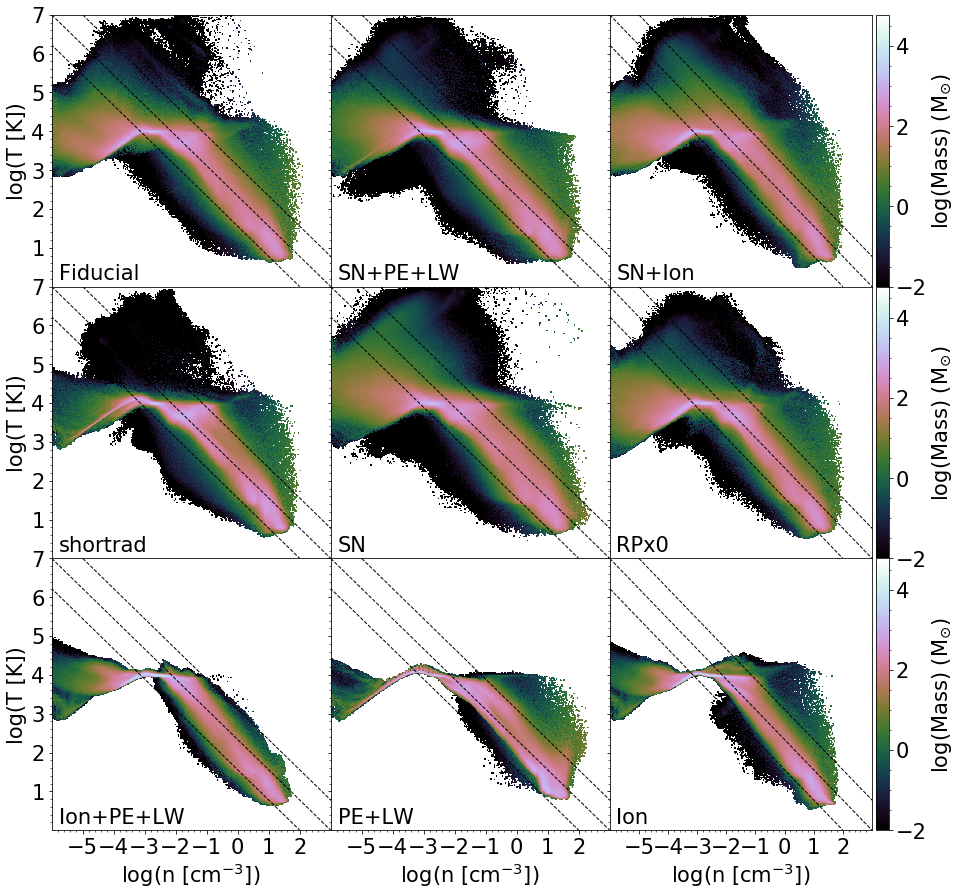

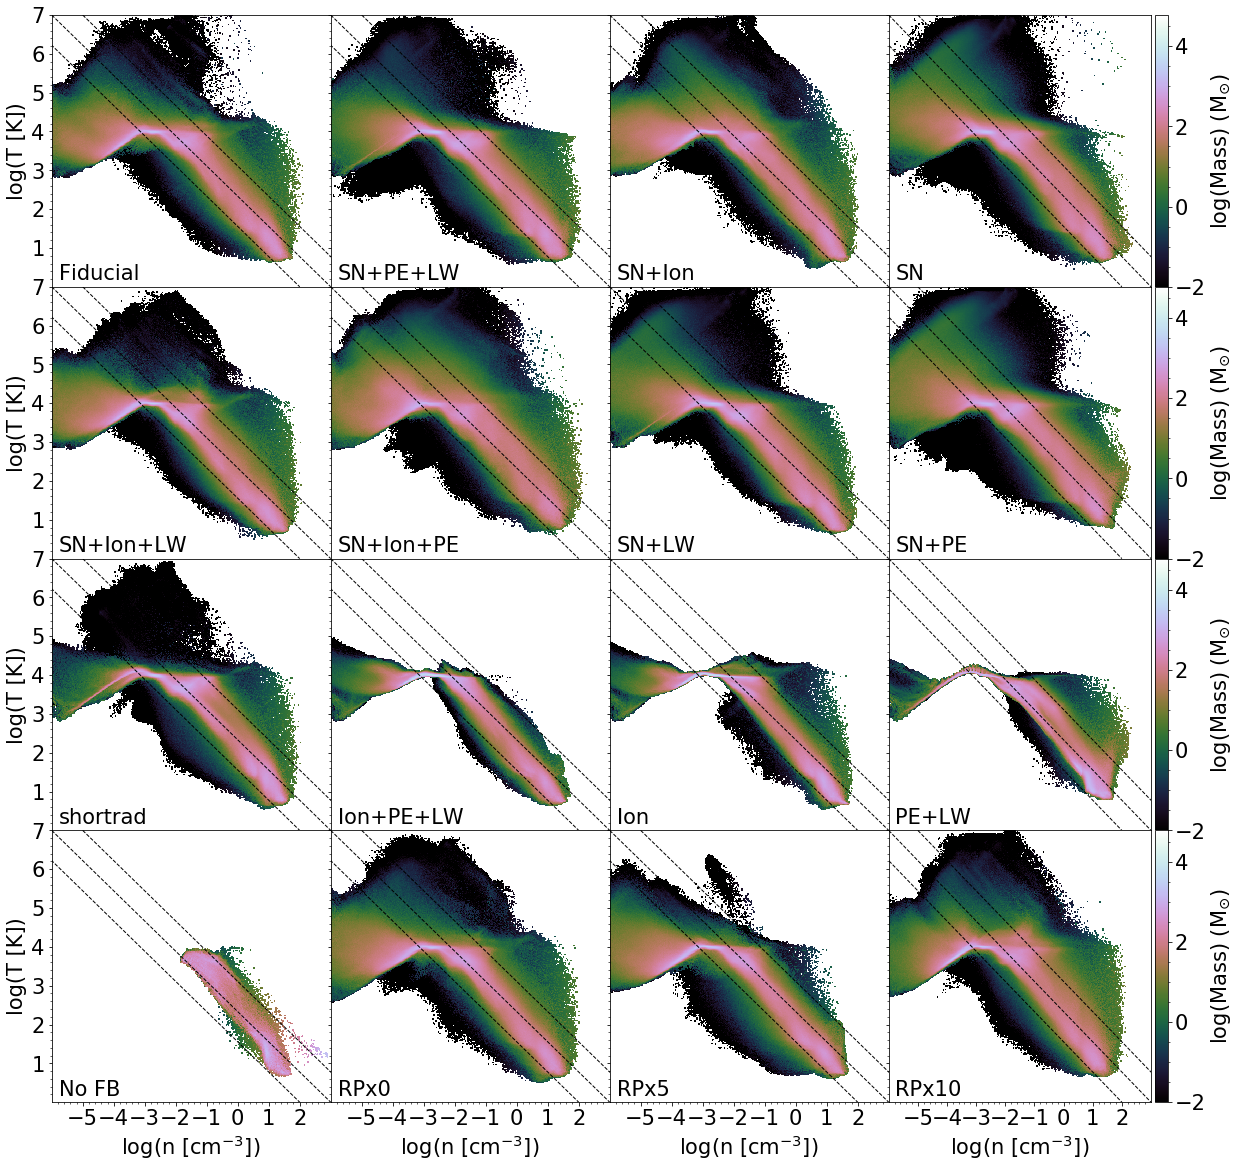

In [6]:
plot_settings()

def plot_phase_diagram(runs = None, outname=None, dims = None, phase_type = 'nT_phase_disk'):
    
    fs = 5

 
    # plot many panel phase diagram
    #
    if runs is None:

        runs = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
                'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
                'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn']
        
    nruns = np.size(runs)
        
    if dims is None:
        
        if nruns >= 7 and nruns <=9:
            nrow, ncol = 3,3
        elif nruns <= 4:
            nrow, ncol = 2,2
        elif nruns > 4 and nruns <= 6:
            nrow, ncol = 2,3
        elif nruns > 9 and nruns <=12:
            
            nrow,ncol = 3,4
        elif nruns > 12:
            nrow,ncol = 4,4
    else:
        nrow,ncol = dims[0],dims[1]
            
    if nruns > nrow * ncol:
        raise ValueError
        
            
    fig, ax = plt.subplots(nrow,ncol, sharex=True, sharey=True)
    fig.set_size_inches(fs*ncol,fs*nrow)
    fig.subplots_adjust(wspace=0,hspace=0)

    #
    #phase_type = 'nT_phase_disk'
    #phase_type = "nT_phase_outside_disk"

    axi,axj=0,0
    for i,run in enumerate(runs):
        axindex = (axi,axj)


        if axi == (nrow-1):
            ax[axindex].set_xlabel(r"log(n [cm$^{-3}$])")
            ax[axindex].set_xticks([-5,-4,-3,-2,-1,0,1,2])

        if axj == 0:
            ax[axindex].set_ylabel(r"log(T [K])")
            ax[axindex].set_yticks([1,2,3,4,5,6,7])


        # iterate for now to work woth continue
        axj = axj + 1
        if axj >= ncol:
            axj = 0
            axi = axi + 1

        if all_data[run] is None:
            print(run, " is None")

        elif all_data[run].data('nT_phase_disk') is None:
            print("Skipping phase diagram for run " + run)
            continue

        phase_data = all_data[run].data(phase_type)

        xmesh = phase_data['2D']['nmesh']
        ymesh = phase_data['2D']['Tmesh']
        zmesh = phase_data['2D']['hist']
        im = ax[axindex].pcolormesh( np.log10(xmesh), np.log10(ymesh), np.log10(zmesh.T), cmap = 'cubehelix',
                                #norm = LogNorm(),
                                     vmin=np.log10(0.01), vmax = np.log10(6.0E4))

        #ax[axindex].annotate(xy,xytext=)
        #ax[axindex].semilogx()
        #ax[axindex].semilogy()
        ax[axindex].set_xlim(-6,3)
        ax[axindex].set_ylim(0,7)

        ax[axindex].plot( [-6,3], [7,0], lw = 1, ls = '--', color = 'black')
        ax[axindex].plot( [-5,4], [7,0], lw = 1, ls = '--', color = 'black')
        ax[axindex].plot( [-7,2], [7,0], lw = 1, ls = '--', color = 'black')


        if axindex[1] == ncol - 1 :
            divider = make_axes_locatable(ax[axindex])
            cax     = divider.append_axes("right", size="5%", pad=0.05)    


            c = fig.colorbar(im, cax=cax)
            c.set_label(r"log(Mass) (M$_{\odot}$)")


        xy = (0.025,0.025)
        ax[axindex].annotate( labels[run], xy=xy,xycoords='axes fraction')

        plt.minorticks_on()

    if outname is None:
        outname = "phase_plot_" + phase_type + ".png"    

    fig.savefig(outname)

plot_phase_diagram()

phase_runs =  ['fiducial','sn_otrad_no-ion','sn_ion-no-otrad','sn_only',
                            'snlw','snpe','snlw_noion','snpe_noion',
                            'shortrad','otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn',
               'nofeed','sn_otrad_ion_noRP', 'sn_otrad_ion_RPx5', 'sn_otrad_ion_RPx10']

plot_phase_diagram( runs = phase_runs,
                   dims = (4,4),
                   outname = 'phase_plot_nT_disk_4x2.png')



Skipping phase diagram for run nofeed


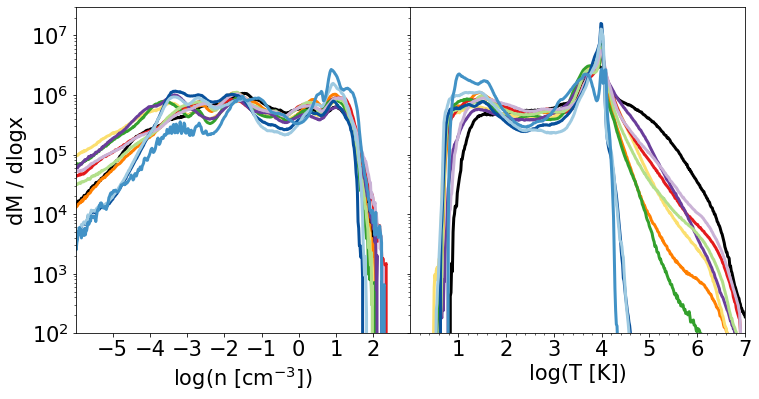

Skipping phase diagram for run nofeed


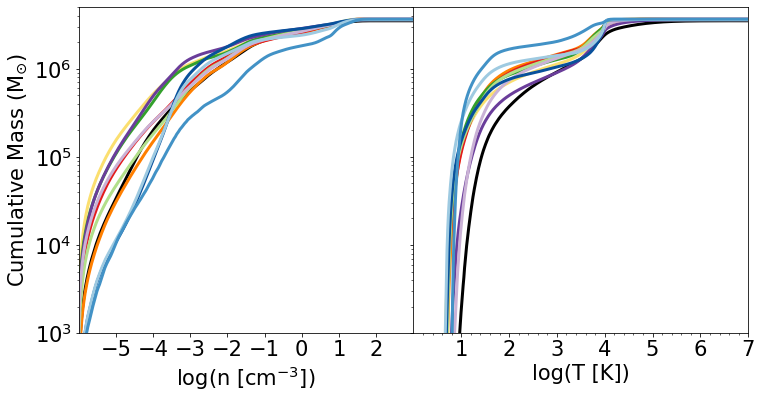

Skipping phase diagram for run nofeed


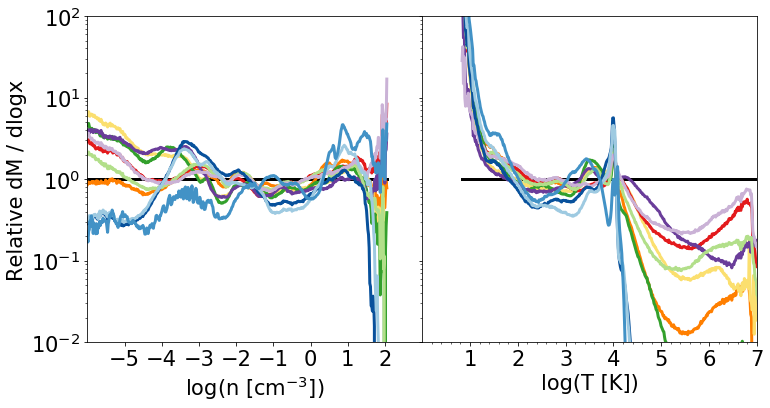

In [35]:
plot_settings()

runs = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
        'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
        'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn','fiducial']

runs = phase_runs

phase_type = 'nT_phase_disk'
#phase_type = "nT_phase_outside_disk"


sharey=True

fig, ax = plt.subplots(1,2,sharey=sharey)
fig.set_size_inches(12,6)

if sharey:
    fig.subplots_adjust(wspace=0)
#
# plot many panel phase diagram
#


for i,run in enumerate(runs):    
    
    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])
        
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])
        
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    nbins = phase_data['1D']['nbins']
    nhist = phase_data['1D']['nhist']
    Tbins = phase_data['1D']['Tbins']
    Thist = phase_data['1D']['Thist']
    
    ax[0].plot(np.log10(nbins), nhist / (np.log10(nbins[1])-np.log10(nbins[0])),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])
    ax[1].plot(np.log10(Tbins), Thist / (np.log10(Tbins[1])-np.log10(Tbins[0])),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])

    ax[0].set_xlim(-6,3)
    ax[1].set_xlim(0,7)
    
    
    
    plt.minorticks_on()

for a in ax:
    a.semilogy()
    a.set_ylim(100,3.0E7)
    
if not sharey:
    ax[0].set_ylabel("dM / dlogn")
    ax[1].set_ylabel("dM / dlogT")
    plt.tight_layout()
else:
    ax[0].set_ylabel(r"dM / dlogx")
                     
fig.savefig("1D_phase_plot_" + phase_type + ".png")
plt.show()
plt.close()
#
#
# plot cumulative
#
#



fig, ax = plt.subplots(1,2,sharey=sharey)
fig.set_size_inches(12,6)
if sharey:
    fig.subplots_adjust(wspace=0)
for i,run in enumerate(runs):    
    
    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])
        
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])
        
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    nbins = phase_data['1D']['nbins']
    nhist = phase_data['1D']['nhist']
    Tbins = phase_data['1D']['Tbins']
    Thist = phase_data['1D']['Thist']
    
    ax[0].plot(np.log10(nbins), np.cumsum(nhist),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])
    ax[1].plot(np.log10(Tbins), np.cumsum(Thist), # where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])

    ax[0].set_xlim(-6,3)
    ax[1].set_xlim(0,7)
    
    
    
    plt.minorticks_on()

for a in ax:
    a.semilogy()
    a.set_ylim(1000,5.0E6)
    
ax[0].set_ylabel(r"Cumulative Mass (M$_{\odot}$)")
if not sharey:
    ax[1].set_ylabel(r"Cumulative Mass (M$_{\odot}$)")
    plt.tight_layout()

fig.savefig("1D_phase_plot_cumulative_" + phase_type + ".png")
plt.show()
plt.close()


#
#
# plot fraction
#
#


fig, ax = plt.subplots(1,2,sharey=sharey)
fig.set_size_inches(12,6)
if sharey:
    fig.subplots_adjust(wspace=0)
#phase_type = "nT_phase_outside_disk"

n_norm = all_data['fiducial'].data(phase_type)['1D']['nhist']
T_norm = all_data['fiducial'].data(phase_type)['1D']['Thist']

for i,run in enumerate(runs):    
    
    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])
        
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])
        
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    nbins = phase_data['1D']['nbins']
    nhist = phase_data['1D']['nhist']
    Tbins = phase_data['1D']['Tbins']
    Thist = phase_data['1D']['Thist']
    
    ax[0].plot(np.log10(nbins[n_norm>0]), nhist[n_norm>0] / n_norm[n_norm>0],# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])
    ax[1].plot(np.log10(Tbins[T_norm>0]), Thist[T_norm>0] / T_norm[T_norm>0], # where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])

    ax[0].set_xlim(-6,3)
    ax[1].set_xlim(0,7)
    
    
    
    plt.minorticks_on()

for a in ax:
    a.semilogy()
    a.set_ylim(0.01,100.0)
    

if not sharey:
    ax[0].set_ylabel("Relative dM / dlogn")    
    ax[1].set_ylabel("Relative dT / dlogT")
    plt.tight_layout()
else:
    ax[0].set_ylabel("Relative dM / dlogx")

fig.savefig("1D_phase_plot_relative_" + phase_type + ".png")


plt.show()
plt.close()


['sn_ion-no-otrad',
 'sn_otrad_no-ion',
 'sn_only',
 'otrad_ion-no-sn',
 'ion_no-otrad-sn',
 'otrad_no-ion-sn',
 'sn_otrad_ion_noRP',
 'shortrad',
 'fiducial']

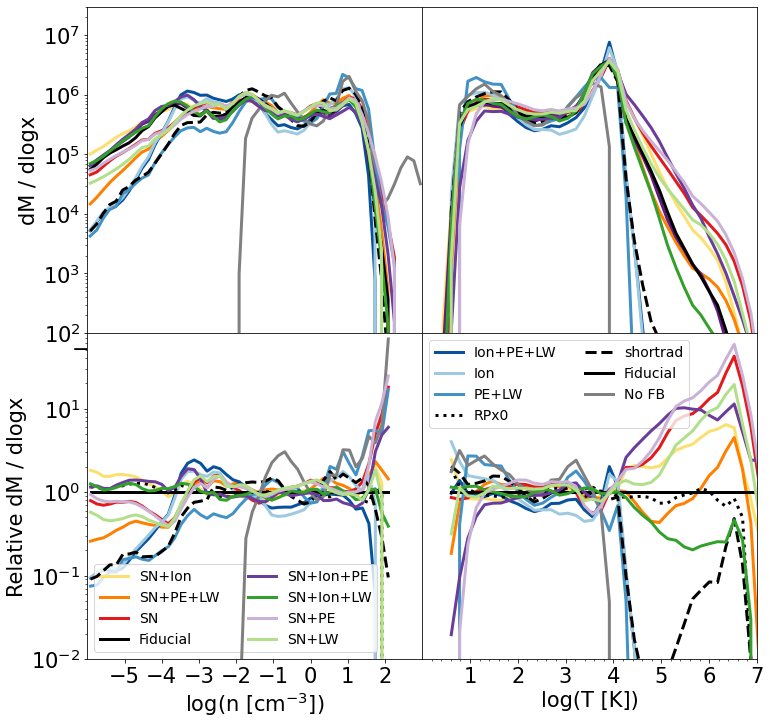

In [39]:
def plot_1D_phase_PDFs(runs = full_base_comparison, outname = "1D_phase_plot_2panel",
                       phase_type = 'nT_phase_disk'):
    
    outname = outname + '_' +phase_type + '.png'
    #phase_type = 'nT_phase_disk'
    #phase_type = "nT_phase_outside_disk"
    
    plot_settings()

    #runs = ['sn_otrad_no-ion', 'sn_ion-no-otrad',
    #        'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
    #        'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn','fiducial']




    sharex,sharey=True,True

    fig, all_axes = plt.subplots(2,2)
    fig.set_size_inches(12,12)

    if sharey:
        fig.subplots_adjust(wspace=0)
    if sharex:
        fig.subplots_adjust(hspace=0)
    #
    # plot many panel phase diagram
    #
    ax = all_axes[0]
    factor = 0.174


    runs_to_label3 = label_set_1 # ['sn_otrad_no-ion','sn_ion-no-otrad','sn_only']
    runs_to_label4 = label_set_2 #['fiducial','shortrad','sn_otrad_ion_noRP']
    runs_to_label1 = [] # ['otrad_no-ion-sn','ion_no-otrad-sn','otrad_ion-no-sn']
    runs_to_label2 = []


    for i,run in enumerate(runs):    

        if all_data[run].data('nT_phase_disk') is None:
            print("Skipping phase diagram for run " + run)
            continue

        phase_data = all_data[run].data(phase_type)

        nbins_orig = phase_data['1D']['nbins']
        nhist_orig = phase_data['1D']['nhist']

        nbins_new = np.zeros(np.size(nbins_orig)+1)
        nbins_new[:-1] = np.log10(nbins_orig) - 0.5*np.average(np.log10(nbins_orig[1:]) - np.log10(nbins_orig[:-1]))
        nbins_new[-1] = nbins_new[-2] + np.average(np.log10(nbins_orig[1:]) - np.log10(nbins_orig[:-1]))



        Tbins_orig = phase_data['1D']['Tbins']
        Thist_orig = phase_data['1D']['Thist']


        nbins, nhist = utilities.simple_rebin(nbins_new, nhist_orig,factor)
        Tbins, Thist = utilities.simple_rebin(np.log10(Tbins_orig),Thist_orig[:-1],factor)

        nplot = 0.5 * (nbins[1:]+nbins[:-1])
        Tplot = 0.5 * (Tbins[1:]+Tbins[:-1])

        if run in runs_to_label1:
            label = labels[run]
        else:
            label = None

        ax[0].plot(nplot, nhist / (nbins[1]-nbins[0]),# where = 'pre',
                          color = colors[run], 
                          label = label,
                          lw=3, ls = lstyles[run], zorder=i)
        if run in runs_to_label2:
            label = labels[run]
        else:
            label = None

        ax[1].plot(Tplot, Thist / (Tbins[1]-Tbins[0]),# where = 'pre',
                          color = colors[run], 
                          label = label,
                          lw=3, ls = lstyles[run], zorder=i)

        ax[0].set_xlim(-6,3)
        ax[1].set_xlim(0,7)



        plt.minorticks_on()


    if not sharex:
        ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
        ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])

    if not sharex:
        ax[1].set_xlabel(r"log(T [K])")
        ax[1].set_xticks([1,2,3,4,5,6,7])    

    for a in ax:
        a.semilogy()
        a.set_ylim(100,3.0E7)

    if not sharey:
        ax[0].set_ylabel("dM / dlogn")
        ax[1].set_ylabel("dM / dlogT")
        plt.tight_layout()
    else:
        ax[0].set_ylabel(r"dM / dlogx")
        ax[1].get_yaxis().set_visible(False)


    #
    #
    # plot fraction
    #
    #
    ax = all_axes[1]

    n_norm_orig = all_data['fiducial'].data(phase_type)['1D']['nhist']
    T_norm_orig = all_data['fiducial'].data(phase_type)['1D']['Thist']

    for i,run in enumerate(runs):    

        if all_data[run].data('nT_phase_disk') is None:
            print("Skipping phase diagram for run " + run)
            continue

        phase_data = all_data[run].data(phase_type)

        nbins_orig = phase_data['1D']['nbins']
        nhist_orig = phase_data['1D']['nhist']


        Tbins_orig = phase_data['1D']['Tbins']
        Thist_orig = phase_data['1D']['Thist']


        nbins, nhist = utilities.simple_rebin(np.log10(nbins_orig),nhist_orig[:-1],factor)
        Tbins, Thist = utilities.simple_rebin(np.log10(Tbins_orig),Thist_orig[:-1],factor)


        nbins_norm, n_norm = utilities.simple_rebin(np.log10(nbins_orig), n_norm_orig[:-1], factor)
        Tbins_norm, T_norm = utilities.simple_rebin(np.log10(Tbins_orig), T_norm_orig[:-1], factor)

        nplot=0.5*(nbins[1:] + nbins[:-1])
        Tplot=0.5*(Tbins[1:] + Tbins[:-1])

        if run in runs_to_label3:
            label = labels[run]
        else:
            label = None

        color, ls = colors[run], lstyles[run]
        
        if run == 'sn_otrad_ion_noRP':
            color, ls = 'black',':'
        
        ax[0].plot(nplot[n_norm>0], (nhist[n_norm>0]/np.sum(nhist))/ (n_norm[n_norm>0]/np.sum(n_norm)),# where = 'pre',
                          color = color, 
                          label = label,
                          lw=3, ls = ls,zorder=i)

        if run in runs_to_label4:
            label = labels[run]
        else:
            label = None

        ax[1].plot(Tplot[T_norm>0], (Thist[T_norm>0]/np.sum(Thist)) / (T_norm[T_norm>0]/np.sum(T_norm)), # where = 'pre',
                          color = color,
                          label = label,
                          lw=3, ls = ls,zorder=i)

        ax[0].set_xlim(-6,3)
        ax[1].set_xlim(0,7)



        plt.minorticks_on()

    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2]) 
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])

    prop = {'size':14}
    all_axes[(1,0)].legend(loc='lower left',ncol=2,prop=prop)
    all_axes[(1,1)].legend(loc='upper left',ncol=2,prop=prop)
    
    #for ax1 in all_axes:
        #for ax2 in ax1:
            #ax2.legend(loc=' left', ncol=2,prop=prop)
    #ax[0].legend(loc='best',ncol=2)

    for a in ax:
        a.semilogy()
        a.set_ylim(0.01,80.0)

    if not sharey:
        ax[0].set_ylabel("Relative dM / dlogn")    
        ax[1].set_ylabel("Relative dT / dlogT")
        plt.tight_layout()

    else:
        ax[0].set_ylabel("Relative dM / dlogx")
        ax[1].get_yaxis().set_visible(False)

    fig.savefig(outname)
    
#----------------------------------------------------------------------------------------------------------

plot_1D_phase_PDFs()

/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


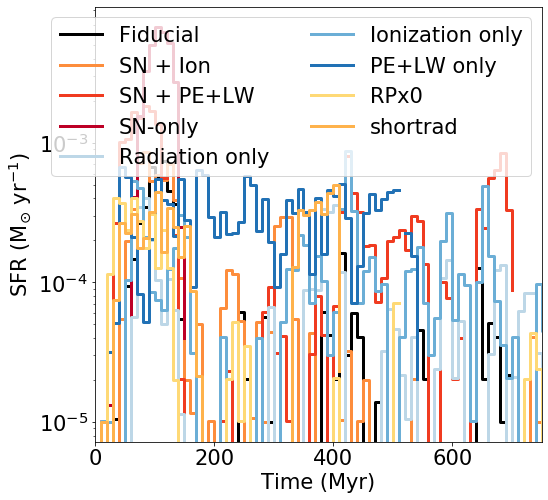

In [385]:
#
# plot a SFR comparison
#
plot_settings()

fig, ax = plt.subplots()
fig.set_size_inches(8,8)

runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
    #ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')
ax.semilogy()

ax.legend(loc='best',ncol = 2)

ax.set_xlim(global_time_lim)
#ax.set_ylim()
fig.savefig('physics_comparison_sfr.png')

x = all_data['sn_only']
x.load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') / x.load_field('M_gas')

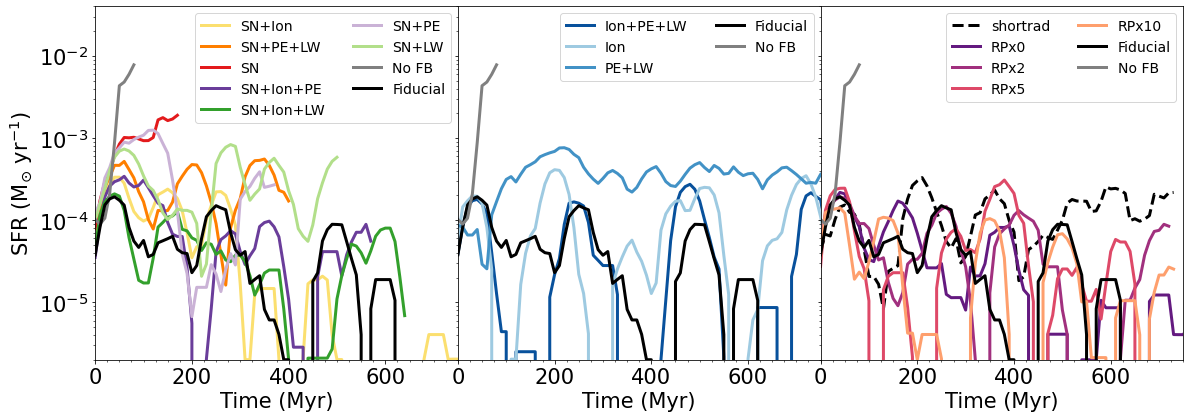

In [40]:
sfr_bin_size = 50.0

FS=6.5

def plot_sfr(runs_to_plot1   = None,
             runs_to_plot2  = None,
             runs_to_plot3  = None,
             outname = 'physics_comparison_sfr_2.png'):
    
    
    if runs_to_plot1 is None:
        runs_to_plot1 = sn_runs + misc_runs + ['fiducial']
        
    if runs_to_plot2 is None:
        runs_to_plot2 = no_sn_runs + ['fiducial']
        
    nrow = 2
    if not (runs_to_plot3 is None):
        nrow = 3

    #
    # plot a SFR comparison
    #
    plot_settings()

    fig, axes = plt.subplots(1,nrow,sharey=True)
    fig.set_size_inches(FS*nrow,FS)

    fig.subplots_adjust(wspace=0)

    #runs_to_plot = base_comparison

    for ax, rtp in zip(axes, [runs_to_plot1,runs_to_plot2,runs_to_plot3]):
        
        if rtp is None:
            continue
            
        for i,run in enumerate(rtp):
            #t = all_data[run].data('time')

            #t = t - t[0]

            # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
            t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
            SFR = all_data[run].load_single('/time_data/SFR',index = -1)

           # print(np.shape(t),np.shape(SFR[:-1])) 
            new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

            #t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, sfr_bin_size, method='average')
            #print(run,t[0])
            SFR = utilities.window_average(t-t[0],
                                             SFR, sfr_bin_size, method='average', where='mid')
            if run == 'fiducial':
                color = 'black'
            else:
                color = "C%0i"%(i)    
            #ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])


            ax.plot(t-t[0], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

            plt.minorticks_on()

    for ax in axes:
        ax.set_xlabel(r'Time (Myr)')
        ax.semilogy()
        ax.set_xlim(global_time_lim)
        ax.set_ylim(2.0E-6,4.0E-2)
        ax.xaxis.set_minor_locator(MultipleLocator(25))        
        
    legend_prop = {'size' : 14}
        
    axes[0].legend(ncol = 2,loc = 'upper right', prop = legend_prop)
    axes[1].legend(loc='best',ncol = 2, prop = legend_prop)
    axes[2].legend(loc='best',ncol = 2, prop = legend_prop)
    axes[0].set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')



    #ax.set_ylim()
    fig.savefig(outname ,bbox_inches='tight', pad_inches=0)

#plot_sfr()
#lstyles

#plot_sfr(sn_runs + ['snpe','snlw','snpe_noion','snlw_noion','shortrad','sn_otrad_ion_noRP','nofeed'] + ['fiducial'],
#         no_sn_runs + ['fiducial','nofeed'], #,,'sn_otrad_ion_noRP','shortrad'],
#         'physics_comparison_sfr.png')



plot_sfr(global_rtp1, global_rtp2, global_rtp3, 'physics_comparison_sfr.png')

In [66]:
sfr_bin_size = 50.0

def plot_RP_comparison(runs_to_plot   = None,
             runs_to_plot2  = None,
             outname = 'physics_RP_comparison.png'):
    
    
    if runs_to_plot is None:
        runs_to_plot = sn_runs + misc_runs + ['fiducial']
        
    if runs_to_plot2 is None:
        runs_to_plot2 = no_sn_runs + ['fiducial']

    #
    # plot a SFR comparison
    #
    plot_settings()

    fig, all_axes = plt.subplots(1,3)
    fig.set_size_inches(24,8)

    #fig.subplots_adjust()

    #runs_to_plot = base_comparison

    ax = all_axes[0]
    for i,run in enumerate(runs_to_plot):
        x = all_data[run].data('time')
        
        y = all_data[run].data('M_star')
        ax.plot(x-x[0],y, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

        plt.minorticks_on()
    ax.set_ylim(1.0E3,3.0E6)
    ax.tick_params(axis='x', which='minor', bottom=True)        



    ax = all_axes[2]
    for i,run in enumerate(runs_to_plot):
        t   = all_data[run].data('time')
        t = t - t[0]

        outflow = all_data[run].load_field("/gas_profiles/outflow/sphere/('gas', 'cell_mass')")
        SFR = np.average(all_data[run].data('SFR_100')[:500])

        
        if run in labels_to_show1:
            label = labels[run]
        else:
            label = None
            
        ax.plot(t, outflow[:,0] / SFR, # bin 0 centered on 0.1 Rvir
                label = label, lw = 3, color = colors[run], ls=lstyles[run])
        
        if run in labels_to_show2:
            label = labels[run]
        else:
            label = None
            
       # ax.plot(t, outflow[:,3] / SFR, # bin 5 centered on Rvir
        #        label = label, lw = 3, color = colors[run], ls=lstyles[run])    

        ax.set_xlabel(r'Time (Myr)')
        ax.set_xlim(global_time_lim)
        ax.set_ylim(0.001,3000)
        ax.semilogy()
        ax.tick_params(axis='x', which='minor', bottom=True)        
        
        
        
        
    ax = all_axes[1]
    for i,run in enumerate(runs_to_plot):        
        x = all_data[run].data('time')

        
        y = all_data[run].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                    all_data[run].data('M_gas')        
        x = x - x[0]

        ax.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])

        ax.set_ylabel(r'<Z$_{\rm ISM}$>')       
        ax.set_xlabel(r'Time (Myr)')
        ax.set_xlim(global_time_lim)
        ax.semilogy()
        ax.set_ylim([6.0E-6,1.0E-3])
        
        ax.tick_params(axis='x', which='minor', bottom=True)        

    for ax in all_axes:
        ax.set_xlabel(r'Time (Myr)')
        ax.semilogy()
        ax.set_xlim(global_time_lim)
    plt.tight_layout()
        
    legend_prop = {'size' : 14}
        
    all_axes[0].legend(ncol = 3,loc = 'upper right', prop = legend_prop)
    #all_axes[1].legend(loc='best',ncol = 2, prop = legend_prop)
    all_axes[0].set_ylabel(r'M$_{*}$ (M$_{\odot}$)')
    #all_axes[1].set_ylabel(r'Z_{rm ISM}>')
    all_axes[2].set_ylabel(r'$\eta_{\rm M}$')



    #ax.set_ylim()
    fig.savefig(outname,bbox_inches='tight')
    plt.close()

#plot_sfr()
#lstyles
plot_RP_comparison(['fiducial','sn_otrad_ion_noRP','sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','sn_otrad_ion_RPx10'])


<ipython-input-66-f3aebf5314d0>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, all_axes = plt.subplots(1,3)


In [41]:
plot_settings()

def plot_masses_comparison(runs_to_plot=base_comparison, labels1=None, labels2=None,
                           outname='physics_comparison_masses.png'):
    #
    # plot a mass comparison
    #
    
    if labels1 is None:
        labels1 = runs_to_plot
        

    fig, axes = plt.subplots(2,2)
    fs = 7
    fig.set_size_inches(fs*2,fs*2)


    ax_fields = ['M_HI','M_star','M_H2_total','Z']
    ax_labels = [r'M$_{\rm H_I}$ (M$_{\odot}$)', r'M$_{\rm *}$ (M$_{\odot}$)',
                 #r'M$_{\rm H_2}$ (M$_{\odot}$)', 
                 r'f$_{\rm H_2}$', 
                 r'<Z$_{\rm ISM}$>']
    ylims = [ [1.0E3,3.0E6], [1.0E3,3.0E6], [1.0E-6,4.0E-2], [6.0E-6,1.0E-3]]             

    #runs_to_plot = base_comparison #+ ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5'] # + ['snlw','snpe']


    index = 0
    axi = axj = 0
    for ax1 in axes:

        axj = 0
        for ax2 in ax1:

            ax_index = (axi,axj)

            for i,run in enumerate(runs_to_plot):
        #t = all_data[run].data('time')

        #t = t - t[0]

                x = all_data[run].data('time')

                if ax_fields[index] == 'Z':
                    y = all_data[run].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                        all_data[run].data('M_gas')

                   # y = all_data[run].data('M_star')

                elif ax_fields[index] == 'M_H2_total':
                    y = all_data[run].data('M_H2_total') / all_data[run].data('M_gas')
                else:

                    y = all_data[run].data(ax_fields[index])

                x = x - x[0]

                if ax_fields[index] == 'Z':
                    ax2.plot(x,y,lw=3,color=colors[run],ls=lstyles[run])
                else:
                    
                    if labels1 is None:
                        
                        ax2.plot(x,y, lw = 3, color = colors[run], ls = lstyles[run])

                    elif (axi == 0) and (axj == 0) and run in labels1:                    
                        ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])
                    else:
                        ax2.plot(x,y, lw = 3, color = colors[run], ls = lstyles[run])
 
                    if labels2 is None:
                        
                        ax2.plot(x,y, lw = 3, color = colors[run], ls = lstyles[run])

                    elif (axi == 0) and (axj == 1) and run in labels2:                    
                        ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])
                    else:
                        ax2.plot(x,y, lw = 3, color = colors[run], ls = lstyles[run])
                                        

            ax2.set_ylabel(ax_labels[index])            
            ax2.set_xlabel(r'Time (Myr)')
            ax2.set_xlim(global_time_lim)
            ax2.semilogy()
            ax2.set_ylim(ylims[index])

            ax2.tick_params(axis='x', which='minor', bottom=True)
            #ax2.tick_params(axis='y', which='minor', bottom=True)


            index = index + 1


            axj = axj + 1

        axi = axi + 1


    closed_box = True

    # overplot closed box model for fiducial run
    if closed_box:
        y = 1.0*all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Total Tracked Metals')
        #print(y[649] - y[650])

        #y[650:] = y[650:] + 513.927    

        y = y +  all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Total Tracked Metals')
        y = y / all_data['fiducial'].load_field('M_gas')[0]
        x = all_data['fiducial'].load_field('time')

        axes[(1,1)].plot(x - x[0], y, color = 'grey', ls = '--', lw = 7, label = 'Closed Box')
        axes[(1,1)].legend(loc='best')
       # axes[(1,1)].legend(loc='best')


    legend_prop = {'size':16}
    axes[(0,0)].legend(loc='best',ncol=2,prop=legend_prop)
    if not (labels2 is None):
        axes[(0,1)].legend(loc='best',ncol=1,prop=legend_prop)


    plt.tight_layout()

    fig.savefig(outname)
    
#plot_masses_comparison()

#plot_masses_comparison(base_comparison + ['nofeed','snpe','snlw',
#                                               'snpe_noion','snlw_noion'],
#                       labels1 = base_comparison + ['nofeed','snpe','snlw',
#                                               'snpe_noion','snlw_noion'],
#                       outname= 'physics_comparison_masses.png')

#plot_masses_comparison(['fiducial-redo','sn_otrad_ion_noRP-redo',
#                        'sn_otrad_ion_RPx2-redo','sn_otrad_ion_RPx5-redo',
#                         'sn_otrad_ion_RPx10-redo'], outname = 'physics_comparison_masses_RP_redo.png')

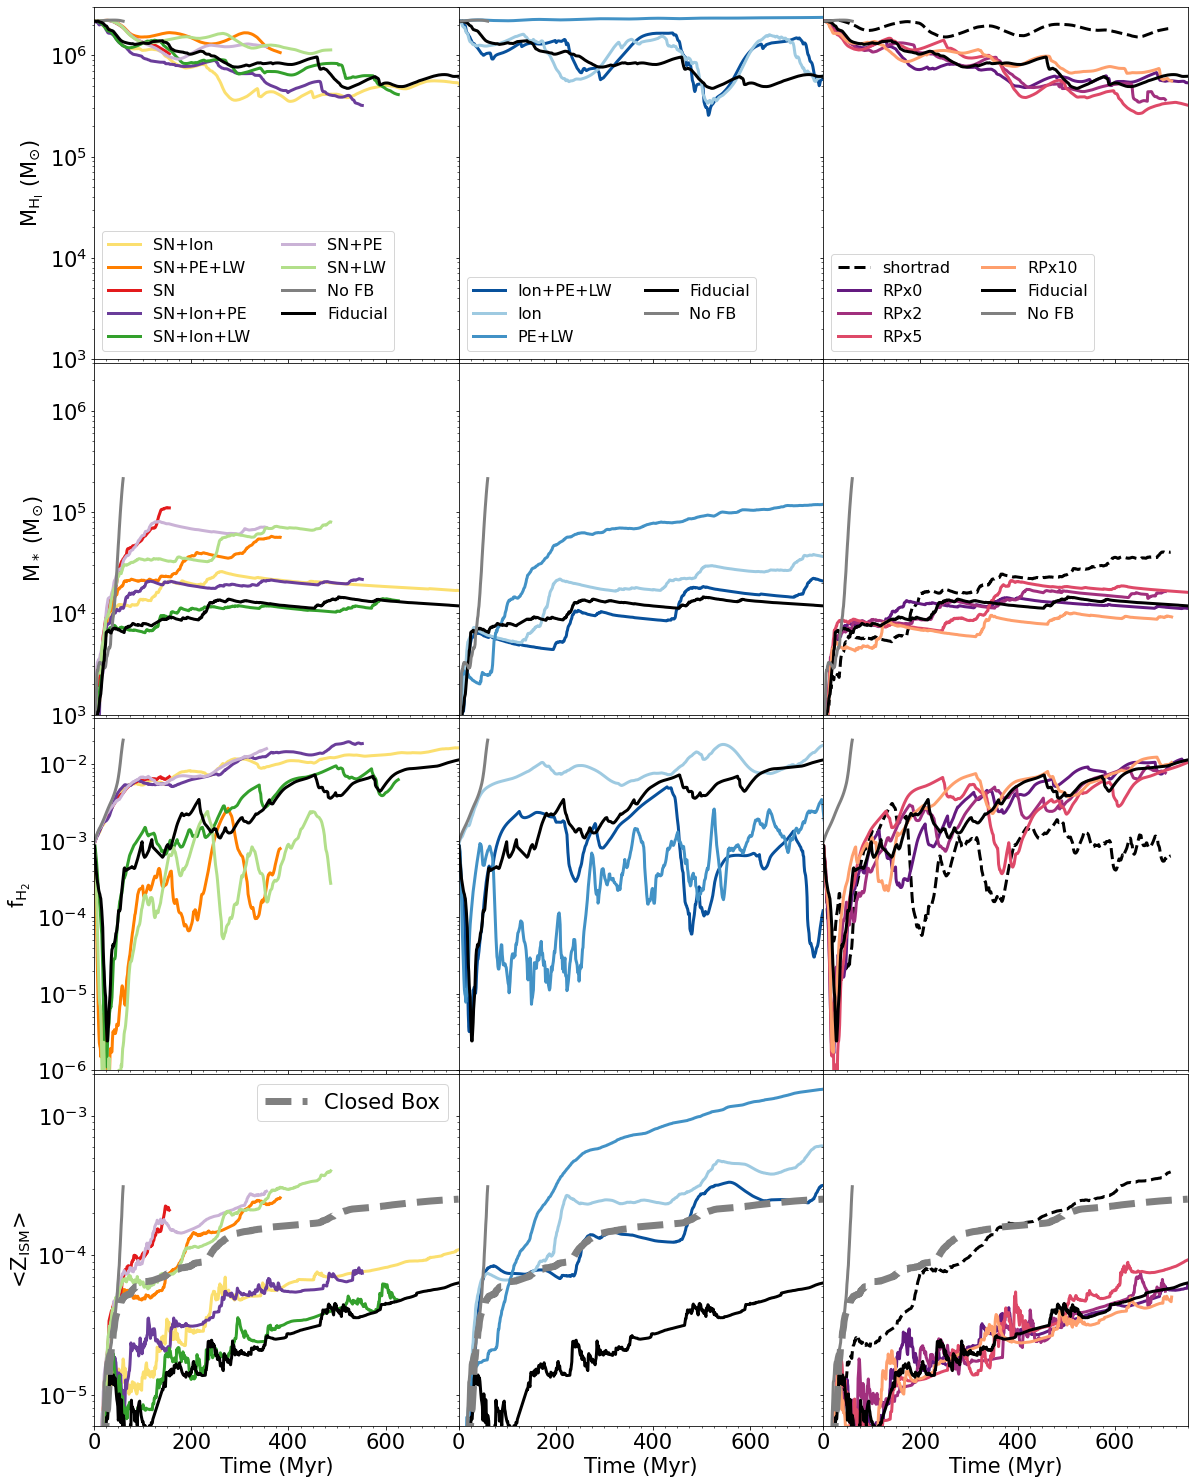

In [48]:
plot_settings()

def plot_masses_comparison_large(runs_to_plot1, runs_to_plot2, runs_to_plot3,
                           outname='physics_comparison_masses.png'):
    #
    # plot a mass comparison
    #
    
    fig, axes = plt.subplots(4,3, sharey='row', sharex=True)
    fs = FS
    fig.set_size_inches(fs*3 + 0.1,fs*4 + 0.1)
    fig.subplots_adjust(wspace=0,hspace=0.01)


    ax_fields = ['M_HI','M_star','M_H2_total','Z']
    ax_labels = [r'M$_{\rm H_I}$ (M$_{\odot}$)', r'M$_{\rm *}$ (M$_{\odot}$)',
                 #r'M$_{\rm H_2}$ (M$_{\odot}$)', 
                 r'f$_{\rm H_2}$', 
                 r'<Z$_{\rm ISM}$>']
    ylims = [ [1.0E3,3.0E6], [1.0E3,3.0E6], [1.0E-6,4.0E-2], [6.0E-6,2.0E-3]]             

    #runs_to_plot = base_comparison #+ ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5'] # + ['snlw','snpe']


    index = 0
    axi = axj = 0
    for ax1 in axes:

        axj = 0
        for ax2,rtp in zip(ax1, [runs_to_plot1,runs_to_plot2,runs_to_plot3]):

            ax_index = (axi,axj)

            for i,run in enumerate(rtp):

                x = all_data[run].data('time')

                if ax_fields[index] == 'Z':
                    y = all_data[run].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                        all_data[run].data('M_gas')

                   # y = all_data[run].data('M_star')

                elif ax_fields[index] == 'M_H2_total':
                    y = all_data[run].data('M_H2_total') / all_data[run].data('M_gas')
                else:

                    y = all_data[run].data(ax_fields[index])

                x = x - x[0]

                if ax_fields[index] == 'Z':
                    ax2.plot(x,y,lw=3,color=colors[run],ls=lstyles[run])
                else:
                    
                    if axi == 0:
                        
                        ax2.plot(x,y, lw = 3, color = colors[run], ls = lstyles[run], label = labels[run])
                    else:
                        ax2.plot(x,y, lw = 3, color = colors[run], ls = lstyles[run])
          

            #ax2.set_xticks([])
            #ax2.set_yticks([])
            ax2.xaxis.set_minor_locator(MultipleLocator(25))            
            ax2.set_xlim(global_time_lim)
            ax2.semilogy()
            ax2.set_ylim(ylims[index])
            
            if axj == 0:
                ax2.set_ylabel(ax_labels[index])   
            if axi == 3:
                ax2.set_xlabel(r'Time (Myr)')
                

            ax2.tick_params(axis='x', which='minor', bottom=True)
            #ax2.tick_params(axis='y', which='minor', bottom=True)




            axj = axj + 1

        axi = axi + 1
        index = index + 1
        




    closed_box = True

    legend_prop = {'size':16}
    for i in np.arange(3):
        axes[(0,i)].legend(loc='lower left',ncol=2,prop=legend_prop)
        

        # overplot closed box model for fiducial run
        if closed_box:
            y = 1.0*all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Total Tracked Metals')
            #print(y[649] - y[650])

            #y[650:] = y[650:] + 513.927    

            y = y +  all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Total Tracked Metals')
            y = y / all_data['fiducial'].load_field('M_gas')[0]
            x = all_data['fiducial'].load_field('time')

            axes[(3,i)].plot(x - x[0], y, color = 'grey', ls = '--', lw = 7, label = 'Closed Box')
    axes[(3,0)].legend(loc='best')
           # axes[(1,1)].legend(loc='best')        
  
    fig.savefig(outname, bbox_inches='tight', pad_inches=0.2)
    
plot_masses_comparison_large(global_rtp1, global_rtp2, global_rtp3,
                       outname= 'physics_comparison_masses_4x3.png')

0.06370814726463307
0.31228265739808614


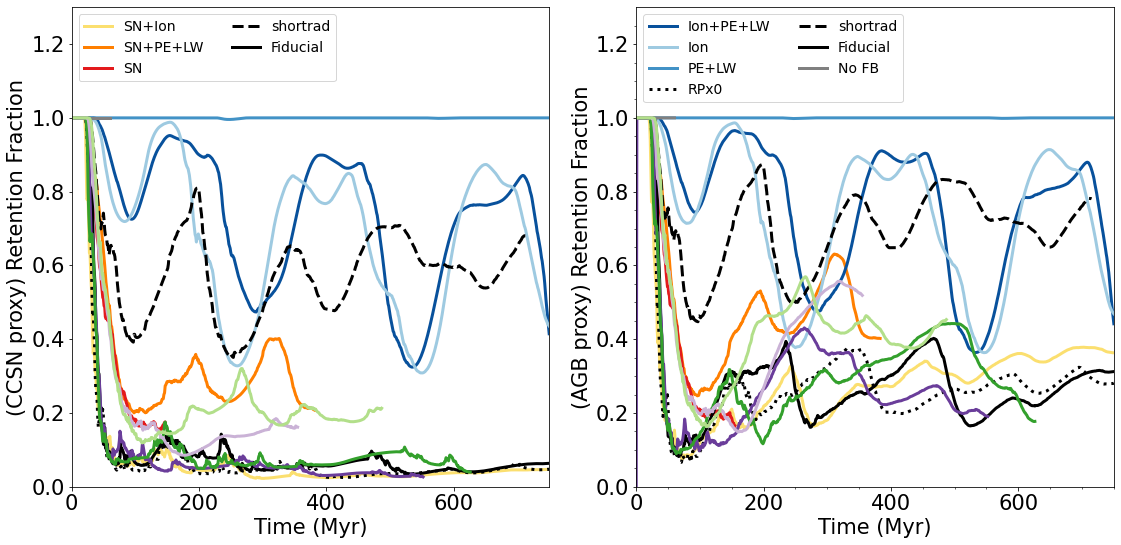

In [60]:
#
# plot a SFR comparison
#

plot_settings()

def plot_retention_comparison(runs_to_plot = base_comparison,
                              outname = "physics_comparison_retention.png",
                              labels_to_show1 = None, labels_to_show2 = None):

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(16,8)

    plt.minorticks_on()
    
    if labels_to_show1 is None:
        labels_to_show1 = ['sn_ion-no-otrad','sn_otrad_no-ion','sn_only','shortrad','fiducial']
        
    if labels_to_show2 is None:
        labels_to_show2 = ['otrad_ion-no-sn','io_no-otrad-sn','otrad_no-ion-sn','sn_otrad_ion_noRP']


    #runs_to_plot = base_comparison + ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5']
    for i,run in enumerate(runs_to_plot):
        #t = all_data[run].data('time')

        #t = t - t[0]

        # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
        t   = all_data[run].data('time')
        t = t - t[0]

        M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
                  all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
        M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
        
        if run in labels_to_show1:
            label =labels[run]
        else:
            label = None
            
        color, ls = colors[run], lstyles[run]
        
        if run == 'sn_otrad_ion_noRP':
            color, ls = 'black',':'            
            
        ax[0].plot(t, ( M_disk / M_tot),
                label = label, lw = 3, color = color,ls=ls)
        if run == 'fiducial':
            print((M_disk/M_tot)[-1])    

        M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
                  all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
        M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')

        #M_disk[t < 150] = None

        if run == 'fiducial':
            print((M_disk/M_tot)[-1])
            
        if run in labels_to_show2:
            label =labels[run]
        else:
            label = None
          
        ax[1].plot(t, (M_disk / M_tot),
                label = label, lw = 3, color =color,ls=ls)
        
    for a in ax:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(global_time_lim)
        a.set_ylim(0, 1.3) #   'shortrad',
    ax[0].set_ylabel(r'(CCSN proxy) Retention Fraction')
    ax[1].set_ylabel(r'(AGB proxy) Retention Fraction')
    
    legend_prop = {'size':14}
    
    ax[0].legend(loc='upper left',ncol=2, prop=legend_prop)
    ax[1].legend(loc='upper left',ncol=2,prop=legend_prop)

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
    plt.minorticks_on()
    plt.tight_layout()
#ax.set_ylim()

    fig.savefig(outname)
    
plot_retention_comparison(full_base_comparison,#+['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','sn_otrad_ion_RPx10'], labels_to_show1=label_set_1, 
                          labels_to_show2=label_set_2)
#plot_retention_comparison(['fiducial','sn_otrad_ion_noRP','sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','sn_otrad_ion_RPx10'],
#                          labels_to_show1=['fiducial','sn_otrad_ion_noRP','sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','sn_otrad_ion_RPx10'],
#                          outname='physics_comparison_retention_RP.png')

In [17]:
#all_data['shortrad'].load_field('/gas_meta_data/masses/OutsideBox/O')
#
# I think this is a units issue with the newly computed data. I think I fixed the old bug
# in ENzo in gearing up for new runs but didn't update analysis scripts oops. need to do this...
# alternatively, just go through and fix ALL output DDXXXX/DDXXXX with correct units and 
# never do this again.

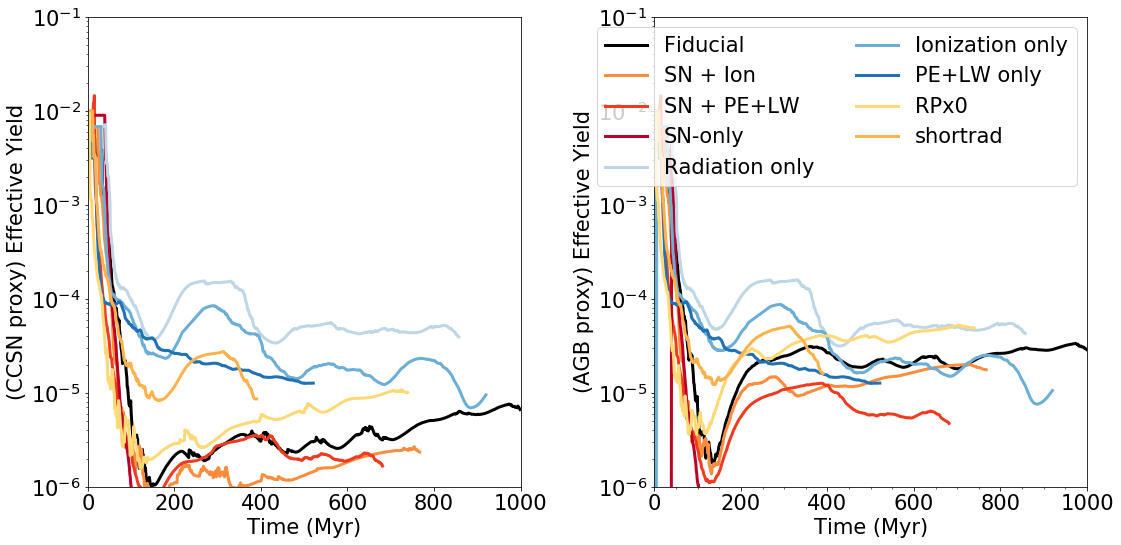

In [394]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_star = all_data[run].load_field('M_star')
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
    ax[0].plot(t, ( M_disk / M_star / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    #if run == 'fiducial':
    #    ax[0].plot(t, M_tot / M_star, label='Onezone', lw=3,color='black',ls='--')
        
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    
    #M_disk[t < 150] = None
    
    ax[1].plot(t, (M_disk / M_star / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    
    
    #if run == 'fiducial':
        #print(M_tot/M_star)
        #ax[1].plot(t, M_tot / M_star, label='Onezone', lw=3,color='black',ls='--')

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(0.0, 1000.0)
    a.semilogy()
    a.set_ylim(1.0E-6,1.0E-1)
  #  a.set_ylim() #   'shortrad',
ax[0].set_ylabel(r'(CCSN proxy) Effective Yield')
ax[1].set_ylabel(r'(AGB proxy) Effective Yield')

#ax.semilogy()

ax[1].legend(loc='upper right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_yield.png")

In [44]:
#
# plot a SFR comparison
#

def plot_outflow_rate(runs_to_plot = base_comparison,
                      labels_to_show1=None,labels_to_show2=None,
                      outname = "physics_comparison_outflow.png"):
    plot_settings()

    fig, ax = plt.subplots(1,2,sharey=True)
    fig.set_size_inches(16,8)

    fig.subplots_adjust(wspace=0)

    plt.minorticks_on()

    if labels_to_show1 is None:
        labels_to_show1 = ['sn_ion-no-otrad','sn_otrad_no-ion','sn_only','shortrad','fiducial']
        
    if labels_to_show2 is None:
        labels_to_show2 = ['otrad_ion-no-sn','io_no-otrad-sn','otrad_no-ion-sn','sn_otrad_ion_noRP']


    #runs_to_plot = base_comparison + ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5']
    for i,run in enumerate(runs_to_plot):
        #t = all_data[run].data('time')

        #t = t - t[0]

        # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
        t   = all_data[run].data('time')
        t = t - t[0]

        outflow = all_data[run].load_field("/gas_profiles/outflow/sphere/('gas', 'cell_mass')")

        #print(run,len(outflow), len(all_data[run].data('SFR_100')))

        SFR = 1.0 # np.average(all_data[run].data('SFR_100')[:500])

        
        if run in labels_to_show1:
            label = labels[run]
        else:
            label = None
            
        ax[0].plot(t, outflow[:,0] / SFR, # bin 0 centered on 0.1 Rvir
                label = label, lw = 3, color = colors[run], ls=lstyles[run])
        
        if run in labels_to_show2:
            label = labels[run]
        else:
            label = None
            
        ax[1].plot(t, outflow[:,3] / SFR, # bin 5 centered on Rvir
                label = label, lw = 3, color = colors[run], ls=lstyles[run])    

    for a in ax:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(global_time_lim)
        a.set_ylim(1.0E-7,0.04) #   'shortrad',
        a.semilogy()

    #ax[0].set_ylabel(r'$\eta_M = \dot{M}_{\rm out}$ / <SFR>')

    xy=(.8,.9)
    ax[0].annotate(r"0.1 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')
    ax[1].annotate(r"1.0 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')

    ax[0].set_ylabel(r'Outflow Rate (M$_{\odot}$ yr$^{-1}$)')

    
    
    legend_prop={'size':14}
    ax[0].legend(loc='lower left',ncol=2,prop=legend_prop)
    ax[1].legend(loc='lower left',ncol=2,prop=legend_prop)
    #ax.semilogy()

    #ax[1].legend(loc='lower right',ncol = 2)
    plt.minorticks_on()
    #plt.tight_layout()
    #ax.set_ylim()
    #plt.show()
    fig.savefig(outname)
    
#plot_outflow_rate(full_base_comparison, label_set_1, label_set_2)

sn_ion-no-otrad 0.0031679290145718996
sn_ion-no-otrad 0.0019553077741608408
sn_ion-no-otrad 52.760926083265176
sn_ion-no-otrad 32.56507594330519
sn_otrad_no-ion 0.002391725296331827
sn_otrad_no-ion 0.00039704917182293724
sn_otrad_no-ion 16.68938910710923
sn_otrad_no-ion 2.7705974985386077
sn_only 0.005759955457500855
sn_only 0.000478098221162903
sn_only 14.916165634158256
sn_only 1.2380985076847237
snpe 0.004730036760708706
snpe 0.0023705698667394657
snpe 89.46243217363913
snpe 44.83621515962096
snlw 0.003678517673138592
snlw 0.0015506674318857435
snlw 115.23941172693893
snlw 48.578807691894866
snpe_noion 0.003866717908414502
snpe_noion 0.0017838616200057144
snpe_noion 17.51293862361798
snpe_noion 8.07937372317849
snlw_noion 0.0032322215397885302
snlw_noion 0.0013075383995763401
snlw_noion 21.77770895032341
snlw_noion 8.809789290992786
nofeed 0.0004673361552605801
nofeed 2.9234723863453045e-06
nofeed 1.5229069115833962
nofeed 0.009526710597655337
fiducial 0.0031996955190314344
fiducial

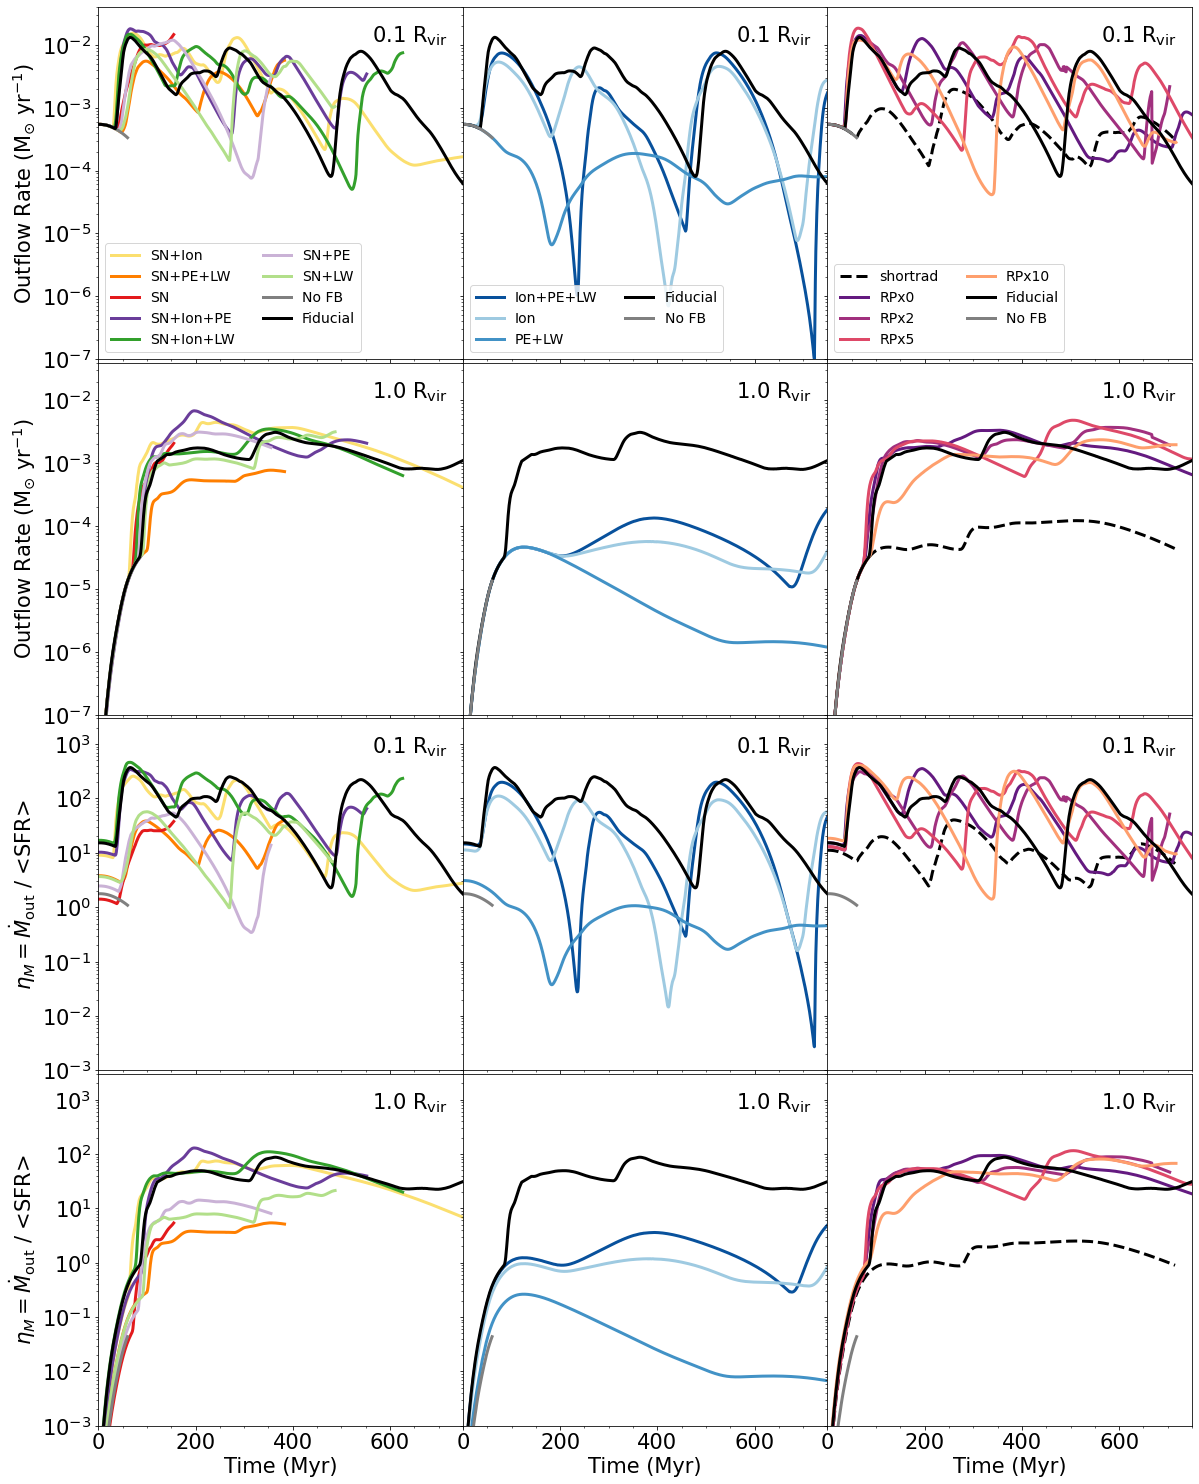

In [52]:
#
# plot a SFR comparison
#

def plot_outflow_rate_panel(rtp1,rtp2,rtp3,
                      outname = "physics_comparison_outflow.png"):
    plot_settings()

    fig, ax = plt.subplots(4,3, sharey='row', sharex=True)
    fs = 6.5
    fig.set_size_inches(fs*3 + 0.1,fs*4 + 0.1)
    fig.subplots_adjust(wspace=0,hspace=0.01)


    plt.minorticks_on()

    for ri, runs_to_plot in enumerate([rtp1, rtp2, rtp3]):

        #runs_to_plot = base_comparison + ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5']
        for i,run in enumerate(runs_to_plot):
            #t = all_data[run].data('time')

            #t = t - t[0]

            # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
            t   = all_data[run].data('time')
            t = t - t[0]

            outflow = all_data[run].load_field("/gas_profiles/outflow/sphere/('gas', 'cell_mass')")

            #print(run,len(outflow), len(all_data[run].data('SFR_100')))

            SFR = 1.0 # np.average(all_data[run].data('SFR_100')[:500])


            label = labels[run]

            ploty = outflow[:,0] / SFR
            print(run, np.average(ploty))
            
            ax[(0,ri)].plot(t, ploty, # bin 0 centered on 0.1 Rvir
                    label = label, lw = 3, color = colors[run], ls=lstyles[run])

            ploty = outflow[:,3] / SFR 
            print(run, np.average(ploty))
            
            ax[(1,ri)].plot(t, ploty, # bin 5 centered on Rvir
                    label = label, lw = 3, color = colors[run], ls=lstyles[run])
            
            SFR = np.average(all_data[run].data('SFR_100')[:500])
    
            ploty = outflow[:,0] / SFR  
            print(run, np.average(ploty))
            ax[(2,ri)].plot(t, ploty, # bin 0 centered on 0.1 Rvir
                    label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
            ploty = outflow[:,3] / SFR   
            print(run, np.average(ploty))

            ax[(3,ri)].plot(t, ploty, # bin 5 centered on Rvir
                    label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])   
        
            
            for j in [0,1,2,3]:
                ax[(j,ri)].set_xlim(global_time_lim)
                ax[(j,ri)].semilogy()
                ax[(j,ri)].xaxis.set_minor_locator(MultipleLocator(25))        

                
            for j in [0,1]:
                ax[(j,ri)].set_ylim(1.0E-7,0.04) #   'shortrad',   
                ax[(j+2,ri)].set_ylim(0.001, 3000)

                

    for i in np.arange(3):
        ax[(3,i)].set_xlabel(r'Time (Myr)')

        #ax[0].set_ylabel(r'$\eta_M = \dot{M}_{\rm out}$ / <SFR>')

    xy=(.75,.9)
    #for i in [0,1]:
    for i in [0,1,2]:
        ax[(0,i)].annotate(r"0.1 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')
        ax[(2,i)].annotate(r"0.1 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')
    
        ax[(1,i)].annotate(r"1.0 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')            
        ax[(3,i)].annotate(r"1.0 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')

    ax[(0,0)].set_ylabel(r'Outflow Rate (M$_{\odot}$ yr$^{-1}$)')
    ax[(1,0)].set_ylabel(r'Outflow Rate (M$_{\odot}$ yr$^{-1}$)')
    ax[(2,0)].set_ylabel(r'$\eta_M = \dot{M}_{\rm out}$ / <SFR>')
    ax[(3,0)].set_ylabel(r'$\eta_M = \dot{M}_{\rm out}$ / <SFR>')

    
    
    legend_prop={'size':14}
    for i in [0,1,2]:
        ax[(0,i)].legend(loc='lower left',ncol=2,prop=legend_prop)
    #so in short I take back the statement on haax[1].legend(loc='lower left',ncol=2,prop=legend_prop)
    #ax.semilogy()

    #ax[1].legend(loc='lower right',ncol = 2)
    plt.minorticks_on()
    #plt.tight_layout()
    #ax.set_ylim()
    #plt.show()
    fig.savefig(outname,bbox_inches='tight',pad_inches=0.2)
    
plot_outflow_rate_panel(global_rtp1, global_rtp2, global_rtp3, outname = 'outflow_panel_4x3.png')

TypeError: list indices must be integers or slices, not tuple

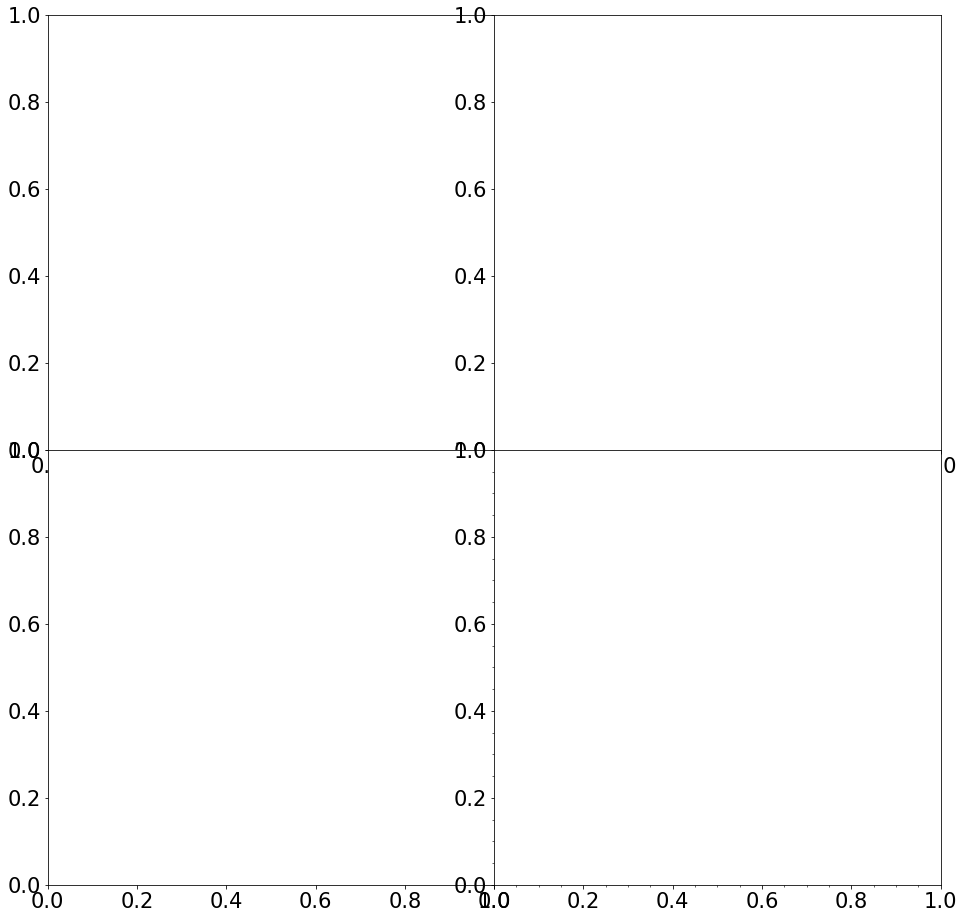

In [8]:
#
# plot a SFR comparison
#
plot_settings()


fig, all_ax = plt.subplots(2,2)
fig.set_size_inches(16,16)

fig.subplots_adjust(wspace=0, hspace = 0)

plt.minorticks_on()

#
# plot a SFR comparison
#
runs_to_plot = full_base_comparison

if True:
    ax = all_ax[0]

    labels_to_show1 = label_set_1
    labels_to_show2 = label_set_2

    #runs_to_plot = base_comparison + ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5']
    for i,run in enumerate(runs_to_plot):
        #t = all_data[run].data('time')

        #t = t - t[0]

        # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
        t   = all_data[run].data('time')
        t = t - t[0]

        outflow = all_data[run].load_field("/gas_profiles/outflow/sphere/('gas', 'cell_mass')")

        #print(run,len(outflow), len(all_data[run].data('SFR_100')))

        SFR = 1.0 # np.average(all_data[run].data('SFR_100')[:500])

        
        if run in labels_to_show1:
            label = labels[run]
        else:
            label = None
            
        ax[0].plot(t, outflow[:,0] / SFR, # bin 0 centered on 0.1 Rvir
                label = label, lw = 3, color = colors[run], ls=lstyles[run])
        
        if run in labels_to_show2:
            label = labels[run]
        else:
            label = None
            
        ax[1].plot(t, outflow[:,3] / SFR, # bin 5 centered on Rvir
                label = label, lw = 3, color = colors[run], ls=lstyles[run])    

    for a in ax:
    #    a.set_xlabel(r'Time (Myr)')
        a.set_xlim(global_time_lim)
        a.set_ylim(1.0E-7,0.04) #   'shortrad',
        a.semilogy()

    #ax[0].set_ylabel(r'$\eta_M = \dot{M}_{\rm out}$ / <SFR>')

    xy=(.8,.9)
    ax[0].annotate(r"0.1 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')
    ax[1].annotate(r"1.0 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')

    ax[0].set_ylabel(r'Outflow Rate (M$_{\odot}$ yr$^{-1}$)')

    
    
    legend_prop={'size':14}
    ax[0].legend(loc='lower left',ncol=2,prop=legend_prop)
    ax[1].legend(loc='lower left',ncol=2,prop=legend_prop)
    ax[1].get_yaxis().set_visible(False)
    
    #ax.semilogy()
    
ax = all_ax[1]
    
runs_to_plot = full_base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    outflow = all_data[run].load_field("/gas_profiles/outflow/sphere/('gas', 'cell_mass')")
    
    #print(run,len(outflow), len(all_data[run].data('SFR_100')))

    SFR = np.average(all_data[run].data('SFR_100')[:500])
    
    ax[0].plot(t, outflow[:,0] / SFR, # bin 0 centered on 0.1 Rvir
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    ax[1].plot(t, outflow[:,3] / SFR, # bin 5 centered on Rvir
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(0.001, 3000) #   'shortrad',
    a.semilogy()
    
ax[0].set_ylabel(r'$\eta_M = \dot{M}_{\rm out}$ / <SFR>')

xy=(.8,.9)
ax[0].annotate(r"0.1 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')
ax[1].annotate(r"1.0 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')
ax[1].get_yaxis().set_visible(False)

#ax[1].set_ylabel(r'Outflow Rate (M$_{\sun}$ yr$^{-1}$)')'

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
#plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_outflow_loading.png")

In [20]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 50
#markers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#           'sn_ion-no-otrad' : 'd',
           

fig, ax = plt.subplots(2,1,sharex=True)
fig.set_size_inches(8,16)
fig.subplots_adjust(hspace=0)

for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Sigma_sfr']
    y = np.log10(all_data[run].loading_table_values['Eta_E_hot'])
    ax[0].scatter( x,
                   y,
                   color = 'C1', s = psize, label = run, marker='o')# markers[run] )

    x = all_data[run].loading_table_values['Sigma_sfr']
    y = np.log10(all_data[run].loading_table_values['Eta_E_cold'])
    xy = (x,y)
    ax[0].scatter( x,y,
                   color = 'C0', s = psize, label = run, marker ='o')
    xy = (x,y)
    ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')    
    #ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')
    
    yline = [all_data[run].loading_table_values['Eta_E_cold'],
             all_data[run].loading_table_values['Eta_E_hot']]
    xline = [ all_data[run].loading_table_values['Sigma_sfr']]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        
        #ax[0].arrow( xline[0], yline[0], dx = 0.0, dy = yline[1] - yline[0],
        #             head_width= 0.1*xline[0],# transform=ax[0].transAxes,
        #             head_length=0.1, fc='k', ec='k')
                      
    yline = np.log10(yline)        
    #else:
        
    ax[0].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    x =all_data[run].loading_table_values['Sigma_sfr']
    y = np.log10(all_data[run].loading_table_values['Eta_E_hot_cold_ratio'])

    ax[1].scatter(x,y,
                   color = colors[run], s = psize, label = run, marker ='o')
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
    
for a in ax:
    a.semilogx()
   # a.semilogy()
    a.set_xlim(1.0E-5,0.01)
    
ax[0].set_ylim(-4,1)
ax[1].set_ylim(-1,2)
#ax[1].legend(loc='best',ncol = 2)
ax[0].set_ylabel(r"Energy loading factor $\eta_E$")
ax[1].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[1].set_ylabel(r"$\eta_{E,h} / \eta_{E,c}$")
#plt.tight_layout()
fig.savefig("phys_comparison_etaE_hot_cold_SFR.png")


<ipython-input-20-94ca85bf838e>:28: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(all_data[run].loading_table_values['Eta_E_hot'])
<ipython-input-20-94ca85bf838e>:61: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(all_data[run].loading_table_values['Eta_E_hot_cold_ratio'])
<ipython-input-20-94ca85bf838e>:28: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(all_data[run].loading_table_values['Eta_E_hot'])
<ipython-input-20-94ca85bf838e>:61: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(all_data[run].loading_table_values['Eta_E_hot_cold_ratio'])
<ipython-input-20-94ca85bf838e>:28: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(all_data[run].loading_table_values['Eta_E_hot'])
<ipython-input-20-94ca85bf838e>:61: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(all_data[run].loading_table_values['Eta_E_hot_cold_ratio'])


In [50]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
#fig.subplots_adjust(hspace=0)

psize = 50

LI = { 'Eta_Z_total' :[0.716,
0.668,
0.894,
0.44,
3.53E-01,
5.00E-01,
2.71E-01,
6.92E-01,
5.00E-01,
5.45E-01,
5.66E-01,
0.21,
0.035,
0.9,
0.8,
0.8,
0.85,
0.87,
0.45,
2.20E-02],
      'Eta_Z_hot' : [0.46,
0.376,
0.55,
0.4,
1.22E-01,
0.1563,
0.0781,
0.0554,
1.04E-01,
7.07E-02,
0.0563,
0.104],
      'Eta_E_total' : [0.224,
0.148,
0.268,
0.18,
6.87E-02,
6.10E-02,
5.02E-02,
6.77E-02,
4.69E-02,
3.09E-02,
4.05E-02,
0.25,
0.01,
0.25,
0.5,
0.55,
0.35,
0.25,
0.13,
2.00E-03],
      'Eta_E_hot' : [0.196,
0.134,
0.244,
0.18,
6.30E-02,
5.50E-02,
4.40E-02,
4.00E-02,
4.10E-02,
2.60E-02,
3.20E-02,
0.2] }

for run in full_base_comparison:
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Eta_metal']
    y = all_data[run].loading_table_values['Eta_E']
        
    ax[0].scatter(x,y,color = colors[run], s = psize, label = run, marker=markers[run])

    
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Eta_metal_hot']
    y = all_data[run].loading_table_values['Eta_E_hot']
        
    ax[1].scatter(x,y,color = colors[run], s = psize, label = run, marker=markers[run])

lw_2 = 1.0
    
for a in ax:

    a.set_xlim(1.0E-3,1.0)
    a.set_ylim(1.0E-3, 1.0)
    
    a.semilogy()
    a.semilogx()
    
    
    a.plot( np.array([1.0E-3,1.0]), np.array([2.0E-3,2.0]), lw = lw_2,         ls = '--',color='black')
    xy = (0.003,0.012) 
    a.text(xy[0], xy[1] , r'2', rotation = 45)    
    a.plot( [1.0E-3,1.0], [1.0E-3,1.0], lw = lw_2, ls = '--',color='black')
    xy = (0.005,0.008) 
    a.text(xy[0], xy[1] , r'1', rotation = 45)
    a.plot( [1.0E-3,1.0], [5.0E-4,0.5], lw = lw_2, ls = '--',color='black')
    xy = (0.005,0.0040) 
    a.text(xy[0], xy[1] , r'0.5', rotation = 45)    
    a.plot( [1.0E-3,1.0], [1.0E-4,0.1], lw = lw_2, ls = '--',color='black')
    xy = (0.009,0.0014) 
    a.text(xy[0], xy[1] , r'0.1', rotation = 45)      
    #a.plot( [1.0E-3,1.0], [5.0E-5,0.05], lw = lw_2, ls = '--',color='black')    

ax[0].set_xlabel("Metal loading factor $\eta_Z$")    
ax[0].set_ylabel("Energy loading factor $\eta_E$")
ax[1].set_xlabel("Metal loading factor $\eta_{Z,h}$")    
ax[1].set_ylabel("Energy loading factor $\eta_{Z,h}$")


ax[1].scatter( LI['Eta_Z_hot'], LI['Eta_E_hot'], color = 'grey', s = psize, marker = 'o', alpha = 0.5,
            label = 'Li & Bryan 2020')
ax[0].scatter( LI['Eta_Z_total'], LI['Eta_E_total'], color = 'grey', s = psize, marker = 'o', alpha = 0.5)

plt.tight_layout()
fig.savefig("phys_comparison_E_loading_Z_loading.png")

<ipython-input-50-43cc9cba726e>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,2)


Eta_Z_total 20
Eta_Z_hot 12
Eta_E_total 20
Eta_E_hot 12


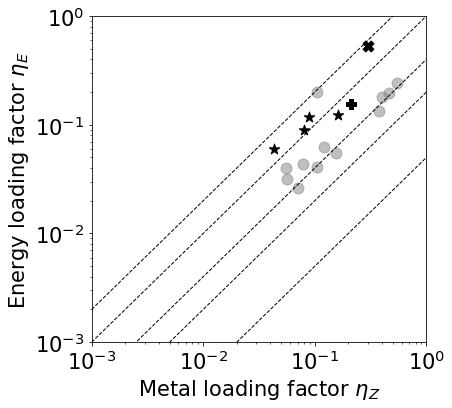

In [272]:
fig,ax = plt.subplots()
fig.set_size_inches(6,6)


xmin, xmax = 999999999,-999999999
ymin, ymax = 999999999,-999999999
for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Eta_metal_hot']
    y = all_data[run].loading_table_values['Eta_E_hot']
        
    ax.scatter(x,y,color = 'black', s = psize, label = run, marker=markers[run])

    xmin = np.min([x, xmin])
    xmax = np.max([x, xmax])
    ymin = np.min([y, ymin])
    ymax = np.max([y, ymax])


ax.set_ylabel("Energy loading factor $\eta_E$")
ax.set_xlabel("Metal loading factor $\eta_Z$")
ax.semilogy()
ax.semilogx()

ax.set_xlim(1.0E-3,1.0)
ax.set_ylim(1.0E-3, 1.0)

lw_2 = 1.0

ax.plot( np.array([1.0E-3,1.0]), np.array([2.0E-3,2.0]), lw = lw_2,         ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [1.0E-3,1.0], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [4.0E-4,0.4], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [2.0E-4,0.2], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [5.0E-5,0.05], lw = lw_2, ls = '--',color='black')
ax.scatter( LI['Eta_Z_hot'], LI['Eta_E_hot'], color = 'grey', s = psize, marker = 'o', alpha = 0.5,
            label = 'Li & Bryan 2020')

#ax.scatter(all_data['fiducial-1.8pc'].loading_table_values['Eta_metal_hot'],
#           all_data['fiducial-1.8pc'].loading_tables_values['Eta_E_hot'], color ='C3')

fig.savefig("phys_comparison_hot_E_loading_Z_loading.png")

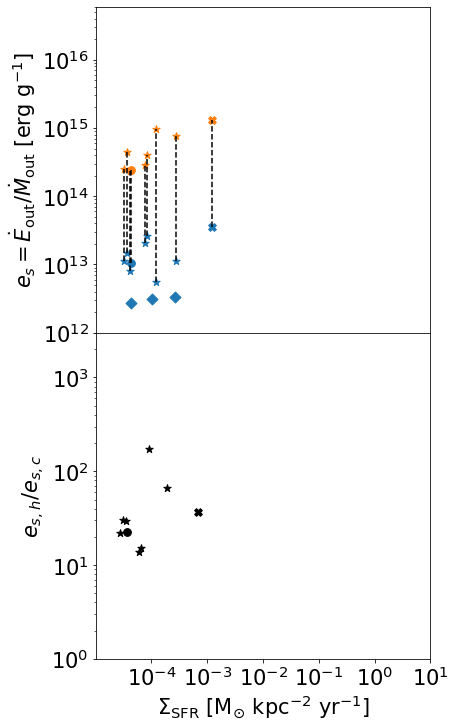

In [160]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 60
#markers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(2,1,sharex=True)
fig.set_size_inches(6,12)
fig.subplots_adjust(hspace=0)

for run in all_data.keys():
    if all_data[run].loading_table_values is None:
        continue
        
    ax[0].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[0].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])
    
    yline = [all_data[run].loading_table_values['e_s_cold'],
             all_data[run].loading_table_values['e_s_hot']]
    xline = [ all_data[run].loading_table_values['Sigma_sfr']]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        
        #ax[0].arrow( xline[0], yline[0], dx = 0.0, dy = yline[1] - yline[0],
        #             head_width= 0.1*xline[0],# transform=ax[0].transAxes,
        #             head_length=0.1, fc='k', ec='k')
                      
        
        
    #else:
        
    ax[0].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[1].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_hot_cold_ratio'],
                   color = 'black', s = psize, label = run, marker = markers[run])
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
    
for a in ax:
    a.semilogx()
    a.semilogy()
    a.set_xlim(1.0E-5,2)
    
ax[0].set_ylim(1.0E12,6.0E16)
ax[1].set_ylim(1.0,3000.0)
#ax[1].legend(loc='best',ncol = 2)
ax[0].set_ylabel(r"$e_s = \dot{E}_{\rm out} / \dot{M}_{\rm out}$ [erg g$^{-1}$]")
ax[1].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[1].set_ylabel(r"$e_{s,h} / e_{s,c}$")

ax[1].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])
plt.minorticks_on()

#plt.tight_layout()
fig.savefig("phys_comparison_e_s_hot_cold_SFR.png")


['sn_ion-no-otrad',
 'sn_otrad_no-ion',
 'sn_only',
 'otrad_ion-no-sn',
 'ion_no-otrad-sn',
 'otrad_no-ion-sn',
 'sn_otrad_ion_noRP',
 'shortrad',
 'fiducial',
 'nofeed',
 'snpe',
 'snlw',
 'snpe_noion',
 'snlw_noion']

sn_ion-no-otrad 75.56 0.2776 0.4347
sn_otrad_no-ion 11.2 0.3601 0.39542
sn_only 9.065 0.3689 0.5706
otrad_ion-no-sn 47.19 0.0698 0.0698
ion_no-otrad-sn 33.98 0.09134 0.09134
otrad_no-ion-sn 0.9404 2.106e-11 2.106e-11
sn_otrad_ion_noRP 101.3 0.3075 0.4411
shortrad 10.57 0.13 0.132041
fiducial 65.6 0.3481 0.4708
snpe 49.07 0.3265 0.49970000000000003
snlw 64.58 0.3634 0.5095000000000001
snpe_noion 7.905 0.2625 0.34509
snlw_noion 8.838 0.3336 0.40075
sn_otrad_ion_RPx2 58.95 0.3426 0.5209
sn_otrad_ion_RPx5 64.52 0.3673 0.5018
sn_otrad_ion_RPx10 76.36 0.5681 0.6468400000000001


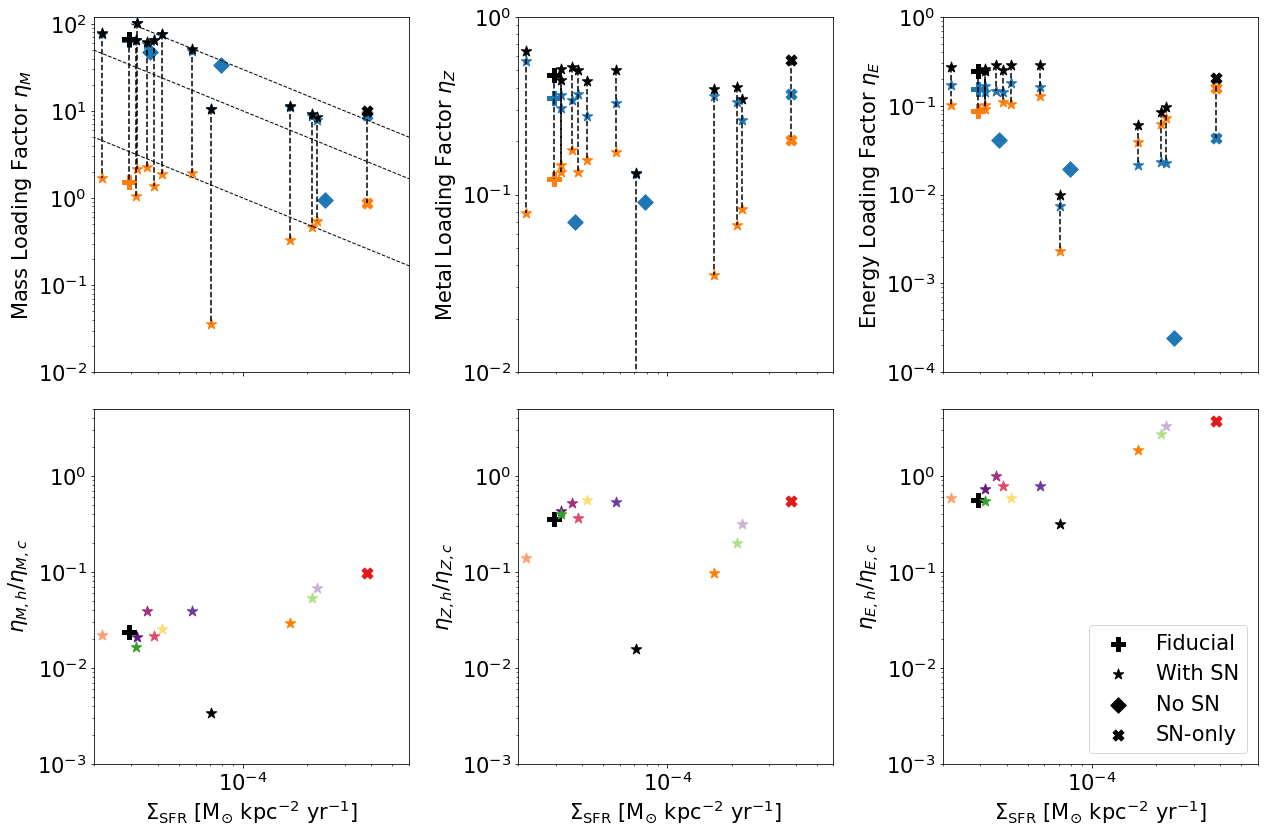

In [58]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)
total_color = 'black'


psize = 120
#arkers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(2,3,sharex=True)
fig.set_size_inches(18,12)
fig.subplots_adjust(hspace=0,wspace=0.25)

sfr_dict = {}

for run in full_base_comparison + ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','sn_otrad_ion_RPx10']:
    if all_data[run].loading_table_values is None:
        continue
        
    if run == 'nofeed':
        continue
        
    if run == 'fiducial':
        psize = 180
    else:
        psize = 120
        
    sfr_dict[run] = all_data[run].loading_table_values['Sigma_sfr']

    if run == 'otrad_no-ion-sn':
        sfr_dict[run] = sfr_dict[run]*0.9 # minor fudge for aesthetic...
    elif run == 'sn_otrad_ion_noRP':
        sfr_dict[run] = sfr_dict[run]*1.1
    
    ax[(0,0)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_mass_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[(0,0)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_mass_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])
    #ax[(0,0)].scatter( sfr_dict[run],
    #               all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
    #               color = total_color, s = psize, label = run, marker = markers[run])   
    
    yline = [all_data[run].loading_table_values['Eta_mass_cold'],
             all_data[run].loading_table_values['Eta_mass_hot']]
    xline = [ sfr_dict[run]]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        #temp = ax[(0,0)].errorbar(sfr_dict[run], yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        #temp[-1][0].set_linestyle('--')
    else:
        yline[0] = yline[1] + yline[0]
        
        ax[(0,0)].scatter(sfr_dict[run],
                   all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[(0,0)].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[(0,1)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_metal_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[(0,1)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_metal_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])   
    #ax[(0,1)].scatter( sfr_dict[run],
    #               all_data[run].loading_table_values['Eta_metal_cold'] + all_data[run].loading_table_values['Eta_metal_hot'],
    #               color = total_color, s = psize, label = run, marker = markers[run])      
    #print(run,all_data[run].loading_table_values['Sigma_sfr'],all_data[run].loading_table_values['Eta_metal_cold'])
    yline = [all_data[run].loading_table_values['Eta_metal_cold'],
             all_data[run].loading_table_values['Eta_metal_hot']]
    xline = [ sfr_dict[run] ]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        #temp = ax[(0,1)].errorbar(sfr_dict[run], yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        #temp[-1][0].set_linestyle('--')
    else:
        yline[0] = yline[1] + yline[0]
        ax[(0,1)].scatter(sfr_dict[run],
                   all_data[run].loading_table_values['Eta_metal_cold'] + all_data[run].loading_table_values['Eta_metal_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[(0,1)].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    yratio = all_data[run].loading_table_values['Eta_mass_hot'] /\
             all_data[run].loading_table_values['Eta_mass_cold']
    
    ax[(1,0)].scatter( sfr_dict[run],
                   yratio,
                   color = colors[run], s = psize, label = run, marker = markers[run])
   
    print(run, all_data[run].loading_table_values['Eta_mass_cold'], all_data[run].loading_table_values['Eta_metal_cold'], all_data[run].loading_table_values['Eta_metal_cold']+all_data[run].loading_table_values['Eta_metal_hot'])

    yratio = all_data[run].loading_table_values['Eta_metal_hot'] /\
             all_data[run].loading_table_values['Eta_metal_cold']
    
    ax[(1,1)].scatter( sfr_dict[run],
                   yratio,
                   color = colors[run], s = psize, label = run, marker = markers[run])
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
############

    x = sfr_dict[run]
    y = all_data[run].loading_table_values['Eta_E_hot']
    ax[(0,2)].scatter( x,
                   y,
                   color = 'C1', s = psize, label = run, marker=markers[run])# markers[run] )

    y = all_data[run].loading_table_values['Eta_E_cold']
    xy = (x,y)
    ax[(0,2)].scatter( x,y,
                   color = 'C0', s = psize, label = run, marker = markers[run])
    #ax[(0,2)].scatter( x , all_data[run].loading_table_values['Eta_E_hot'] +  all_data[run].loading_table_values['Eta_E_cold'],
    #               color = total_color, s = psize, label = run, marker = markers[run])    
    #xy = (x,y)
    #ax[(0,2)].annotate(labels[run], xy, xytext=xy, xycoords='data')    
    #ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')
    
    yline = [all_data[run].loading_table_values['Eta_E_cold'],
             all_data[run].loading_table_values['Eta_E_hot']]
    xline = [ sfr_dict[run] ]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        #temp = ax[(0,2)].errorbar(sfr_dict[run], yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        #temp[-1][0].set_linestyle('--')
    
    else:
        yline[1] = np.min([all_data[run].loading_table_values['Eta_E_cold'],all_data[run].loading_table_values['Eta_E_hot']])
        yline[0] = np.sum([all_data[run].loading_table_values['Eta_E_cold'],all_data[run].loading_table_values['Eta_E_hot']])
        
        ax[(0,2)].scatter(sfr_dict[run],
                   all_data[run].loading_table_values['Eta_E_cold'] + all_data[run].loading_table_values['Eta_E_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[(0,2)].plot( xline,
                        yline,
                        lw = 1.5, color = 'black',
                        ls = '--')
        
        
    y = all_data[run].loading_table_values['Eta_E_hot_cold_ratio']

    ax[(1,2)].scatter(x,y,
                   color = colors[run], s = psize, marker = markers[run])

# marker labels
ax[(1,2)].scatter(-1,-1,color='black',s=180, marker = 'P', label = 'Fiducial')
ax[(1,2)].scatter(-1,-1,color='black',s=psize, marker = '*', label = 'With SN')
ax[(1,2)].scatter(-1,-1,color='black',s=psize, marker = 'D', label = 'No SN')
ax[(1,2)].scatter(-1,-1,color='black',s=psize, marker = 'X', label = 'SN-only')
#ax[(1,2)].scatter(-1,-1,color='black',s=psize, marker = 's', label = 'No FB')



for a2 in ax:
    for a in a2:
        a.semilogx()
        a.semilogy()
        a.set_xlim(2.0E-5,6.0E-4)
    
#ax[0].set_ylim(1.0E12,6.0E16)
#ax[1].set_ylim(1.0,3000.0)
#ax[1].legend(loc='best',ncol = 2)
ax[(0,0)].set_ylabel(r"Mass Loading Factor $\eta_M$")
ax[(0,1)].set_ylabel(r"Metal Loading Factor $\eta_Z$")
ax[(0,2)].set_ylabel(r"Energy Loading Factor $\eta_E$")

ax[(1,0)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[(1,1)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[(1,2)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")

ax[(1,0)].set_ylabel(r"$\eta_{M,h} / \eta_{M,c}$")
ax[(1,1)].set_ylabel(r"$\eta_{Z,h} / \eta_{Z,c}$")
ax[(1,2)].set_ylabel(r"$\eta_{E,h} / \eta_{E,c}$")

#ax[(1,0)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])
#ax[(1,1)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])

plt.minorticks_on()

ax[(0,0)].set_ylim(1.0E-2,120.0)
ax[(0,1)].set_ylim(1.0E-2,1.0)
ax[(0,2)].set_ylim(1.0E-4,1.0)

ax[(1,0)].set_ylim(0.001,5.0)
ax[(1,1)].set_ylim(0.001,5.0)
ax[(1,2)].set_ylim(0.001,5.0)

ax[(1,2)].legend(loc='lower right')


ax[(0,0)].plot([1.0E-5,1.0E-1],[100.0,0.01],lw=1,ls='--',color='black')
ax[(0,0)].plot([3.0E-5,0.3],   [100.0,0.01],lw=1,ls='--',color='black')
ax[(0,0)].plot([1.0E-6,0.01],   [100.0,0.01],lw=1,ls='--',color='black')

#ax[(0,1)].plot([1.0E-5,1.0E-1],[1.0,0.01],lw=1,ls='--',color='black')
#ax[(0,1)].plot([3.0E-5,0.3],   [1.0,0.01],lw=1,ls='--',color='black')
#ax[(0,1)].plot([1.0E-6,0.01],   [1.0,0.01],lw=1,ls='--',color='black')

plt.tight_layout()
fig.savefig("phys_comparison_mass_metal_hot_cold_SFR.png",bbox_inches='tight')


In [49]:
indexes = np.argsort( np.array(list( sfr_dict.values())))



for i in indexes:
    print("%30s    %5.5E"%( list(sfr_dict.keys())[i], list(sfr_dict.values())[i] ))    


                      fiducial    2.93900E-05
                          snlw    3.16700E-05
             sn_otrad_ion_noRP    3.17240E-05
               otrad_ion-no-sn    3.68400E-05
               sn_ion-no-otrad    4.18200E-05
                          snpe    5.74100E-05
                      shortrad    7.10900E-05
               ion_no-otrad-sn    7.86400E-05
               sn_otrad_no-ion    1.65400E-04
                    snlw_noion    2.11100E-04
                    snpe_noion    2.23300E-04
               otrad_no-ion-sn    2.43180E-04
                       sn_only    3.81600E-04


In [250]:
markers

{'sn_only': 'X',
 'ion_no-otrad-sn': 'D',
 'otrad_ion-no-sn': 'D',
 'otrad_no-ion-sn': 'D',
 'shortrad': '*',
 'shortrad_72pc': '*',
 'sn_ion-no-otrad': '*',
 'sn_otrad_no-ion': '*',
 'snlw': '*',
 'snpe': '*',
 'sn_otrad_ion_RPx2': '*',
 'sn_otrad_ion_RPx5': '*',
 'sn_otrad_ion_noRP': '*',
 'fiducial-1.8pc': 'P',
 'fiducial': 'P'}

NameError: name 'total_color' is not defined

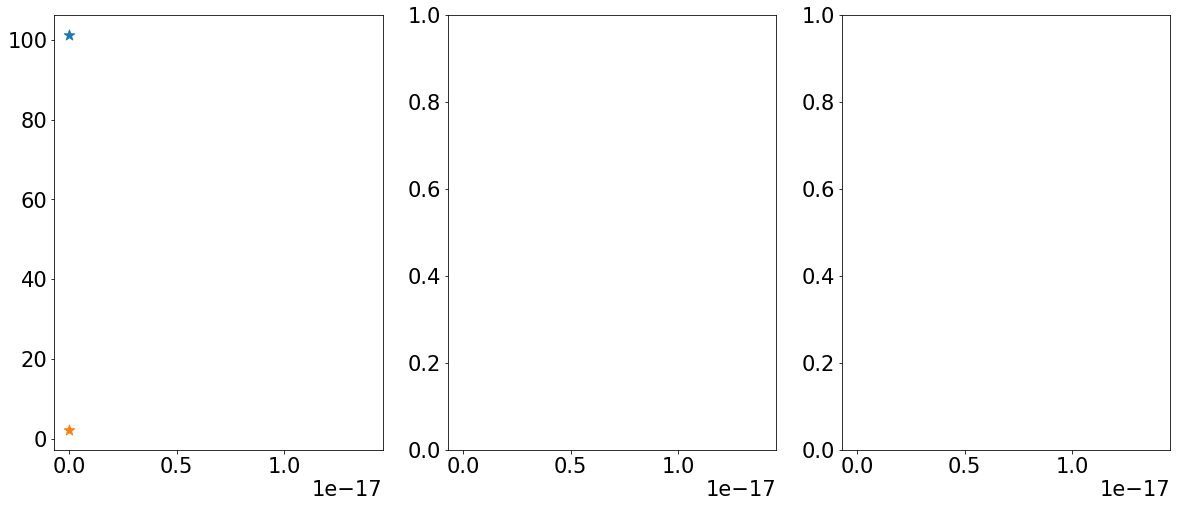

In [53]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 120
#arkers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(1,3,sharex=True)
fig.set_size_inches(20,8)
#fig.subplots_adjust(hspace=0,wspace=0.25)

sfr_dict = {}
for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
            
    sfr_dict[run] = all_data[run].loading_table_values['Sigma_sfr']
sfr_sort= np.argsort( list(sfr_dict.values()))
i = 0
for run in np.array(list(sfr_dict.keys()))[sfr_sort]:
    if all_data[run].loading_table_values is None:
        continue
        
    if run == 'fiducial':
        psize = 180
    else:
        psize = 120
        
    xval = i
    cval = sfr_dict[run]
    

    ax[0].scatter( xval,
                   all_data[run].loading_table_values['Eta_mass_hot'],
                   color = 'C1', s = psize, marker=markers[run])
    ax[0].scatter( xval,
                   all_data[run].loading_table_values['Eta_mass_cold'],
                   color = 'C0', s = psize, marker = markers[run])
    ax[0].scatter( xval,
                   all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
                   color = total_color, s = psize,  marker = markers[run])   
    
    yline = [all_data[run].loading_table_values['Eta_mass_cold'],
             all_data[run].loading_table_values['Eta_mass_hot']]
    xline = [ xval]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        temp = ax[0].errorbar(xval, yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        temp[-1][0].set_linestyle('--')
    else:
        ax[0].scatter(xval,
                   all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
                   color = total_color, s = psize, marker = markers[run]) 
        ax[0].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[1].scatter( xval,
                   all_data[run].loading_table_values['Eta_metal_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[1].scatter( xval,
                   all_data[run].loading_table_values['Eta_metal_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])   
     
    #print(run,all_data[run].loading_table_values['Sigma_sfr'],all_data[run].loading_table_values['Eta_metal_cold'])
    yline = [all_data[run].loading_table_values['Eta_metal_cold'],
             all_data[run].loading_table_values['Eta_metal_hot']]
    xline = [ xval]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        temp = ax[1].errorbar(xval, yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        temp[-1][0].set_linestyle('--')
    else:
        ax[1].scatter(xval,
                   all_data[run].loading_table_values['Eta_metal_cold'] + all_data[run].loading_table_values['Eta_metal_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[1].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
############

    y = all_data[run].loading_table_values['Eta_E_hot']
    ax[2].scatter( xval,
                   y,
                   color = 'C1', s = psize, marker=markers[run])# markers[run] )

    x = all_data[run].loading_table_values['Sigma_sfr']
    y = all_data[run].loading_table_values['Eta_E_cold']
    xy = (x,y)
    ax[2].scatter( xval,y,
                   color = 'C0', s = psize, marker = markers[run])

    #xy = (x,y)
    #ax[(0,2)].annotate(labels[run], xy, xytext=xy, xycoords='data')    
    #ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')
    
    yline = [all_data[run].loading_table_values['Eta_E_cold'],
             all_data[run].loading_table_values['Eta_E_hot']]
    xline = [ xval]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        
        #ax[0].arrow( xline[0], yline[0], dx = 0.0, dy = yline[1] - yline[0],
        #             head_width= 0.1*xline[0],# transform=ax[0].transAxes,
        #             head_length=0.1, fc='k', ec='k')
        
        temp = ax[2].errorbar(xval, yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'C0')
        temp[-1][0].set_linestyle('--')
                      
    else:

    
        ax[2].scatter(xval, all_data[run].loading_table_values['Eta_E_hot'] + all_data[run].loading_table_values['Eta_E_cold'],
                  color = total_color, s = psize,marker = markers[run])        
        ax[2].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    i = i + 1


# marker labels
ax[0].scatter(-1,-1,color='black',s=180, marker = 'P', label = 'Fiducial')
ax[0].scatter(-1,-1,color='black',s=psize, marker = '*', label = 'With SN')
ax[0].scatter(-1,-1,color='black',s=psize, marker = 'D', label = 'No SN')
ax[0].scatter(-1,-1,color='black',s=psize, marker = 'X', label = 'SN-only')


xticklabels = [labels[run] for run in np.array( list(sfr_dict.keys()))[sfr_sort]]

for a in ax:
    a.semilogy()
    a.set_xlim(-1,i)
    a.set_xticks(np.arange(0,i))
    a.set_xticklabels(xticklabels, rotation='vertical')
    
#ax[0].set_ylim(1.0E12,6.0E16)
#ax[1].set_ylim(1.0,3000.0)
#ax[1].legend(loc='best',ncol = 2)
ax[0].set_ylabel(r"Mass Loading Factor $\eta_M$")
ax[1].set_ylabel(r"Metal Loading Factor $\eta_Z$")
ax[2].set_ylabel(r"Energy Loading Factor $\eta_E$")

#ax[(1,0)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
#ax[(1,1)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
#ax[(1,2)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")

#ax[(1,0)].set_ylabel(r"$\eta_{M,h} / \eta_{M,c}$")
#ax[(1,1)].set_ylabel(r"$\eta_{Z,h} / \eta_{Z,c}$")
#ax[(1,2)].set_ylabel(r"$\eta_{E,h} / \eta_{E,c}$")

#ax[(1,0)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])
#ax[(1,1)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])

plt.minorticks_on()

ax[0].set_ylim(1.0E-2,100.0)
ax[1].set_ylim(1.0E-2,1.0)
ax[2].set_ylim(1.0E-4,1.0)

ax[0].legend(loc='lower left',ncol=2)


plt.tight_layout()
fig.savefig("phys_comparison_bar_mass_metal_hot_cold_SFR.png")


In [13]:
plot_settings()

fs = 4

show_axis = False

def plot_image_panel(time,axis):

    nrow,ncol=4,4
    
    fig, ax = plt.subplots(nrow,ncol, sharex=True, sharey=True)
    fig.set_size_inches(fs*ncol,fs*nrow)
    #fig.subplots_adjust(wspace=0,hspace=0)
    fig.subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.95,
                    wspace=0.0, hspace=0.00)
    #
    # plot many panel phase diagram
    #


    runs =  ['fiducial','sn_otrad_no-ion','sn_ion-no-otrad','sn_only',
                            'snlw','snpe','snlw_noion','snpe_noion',
                            'shortrad', 'otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn',
                            'sn_otrad_ion_noRP',  'sn_otrad_ion_RPx2',  'sn_otrad_ion_RPx5','sn_otrad_ion_RPx10']
    image_type = 'proj'
    xlim = [-2.5,2.5]
    ylim = [2.5, 2.5]
    #phase_type = "nT_phase_outside_disk"
    im = None

    axi,axj=0,0
    for i,run in enumerate(runs):
        axindex = (axi,axj)


        if show_axis:
            if axi == 2:
                ax[axindex].set_xlabel(r"x (kpc)")
                ax[axindex].set_xticks([-1.0,-0.5,0,0.5,1.0])        
               

            if axj == 0:
                ax[axindex].set_ylabel(r"y (kpc)")
                ax[axindex].set_yticks([-1.0,-0.5,0,0.5,1.0])
             
            else:
                ax[axindex].set_yticks([])
            #ax[axindex].set_yticks([1,2,3,4,5,6,7])
            ax[axindex].set_yticks([-1.0,-0.5,0,0.5,1.0])
        else:
            ax[axindex].set_xticks([])
            ax[axindex].set_yticks([])
           


        # iterate for now to work woth continue
        axj = axj + 1
        if axj >= ncol:
            axj = 0
            axi = axi + 1
        xy = (0.025,0.025)
        ax[axindex].annotate( labels[run], xy=xy,xycoords='axes fraction', color='white')
        
        image_data = all_data[run].load_image(time, "('gas', 'number_density')",axis, "proj")

        if image_data is None:
            print("Missing data for run ", run)
            
            continue
            
        if axindex[1] == (ncol-1) and axindex[0] == (nrow-1):
            xy = (0.025, 0.925)
            ax[axindex].annotate("250 pc", xy =xy, xycoords='axes fraction', color = 'white')
            shift = 0.1
            ax[axindex].plot([-1.125+shift,-0.875+shift],[0.98,0.98], lw = 4, color = 'white')



        im = ax[axindex].imshow(image_data, cmap = 'viridis', norm = LogNorm(),
                                vmin = 2.0E-4, vmax = 100.0,                                
                                extent=[-1.25,1.25,-1.25,1.25])
        

                                     #vmin=np.log10(0.01), vmax = np.log10(6.0E4))

        #ax[axindex].annotate(xy,xytext=)
        #ax[axindex].semilogx()
        #ax[axindex].semilogy()
        ax[axindex].set_xlim(-1.25,1.25)
        ax[axindex].set_ylim(-1.25,1.25)
        #ax[axindex].set_ylim(0,7)
        #if axindex[0] == 2:
        #    ax[axindex].xaxis.set_xticks(np.arange(-2.5,3.0,0.5))
        


        if False:
            if axindex[1] == (ncol-1):
                divider = make_axes_locatable(ax[axindex])
                cax     = divider.append_axes("right", size="4%", pad=0.0)    


                c = fig.colorbar(im, cax=cax)
                c.set_label(r"Number Density (cm$^{-3}$)")
                

        plt.minorticks_on()
    
    cb_ax = fig.add_axes([0.95, 0.02, 0.01, 0.97])
    if not (im is None):
        cbar = fig.colorbar(im, cax=cb_ax)

 #set the colorbar ticks and tick labels
    #cbar.set_ticks(np.arange(0, 1.1, 0.5))
        cbar.set_label(r"Number Density (cm$^{-3}$)")
    
    
    fig.savefig("proj_panel_3/proj_plot_n_" + axis + "_" + "%03i"%(time) + ".png", bbox_inches="tight")

    plt.close()
    return

for i in np.arange(350,376,25):
    plot_image_panel(i,'z')
    plot_image_panel(i,'x')    

Cannot find ds DD0439 or one +/- 1 away 439 sn_only
Missing data for run  sn_only
Cannot find ds DD0439 or one +/- 1 away 439 sn_only
Missing data for run  sn_only
Cannot find ds DD0464 or one +/- 1 away 464 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0464 or one +/- 1 away 464 sn_only
Missing data for run  sn_only
Cannot find ds DD0464 or one +/- 1 away 464 snlw
Missing data for run  snlw
Cannot find ds DD0463 or one +/- 1 away 463 snpe
Missing data for run  snpe
Cannot find ds DD0464 or one +/- 1 away 464 snpe_noion
Missing data for run  snpe_noion
Cannot find ds DD0464 or one +/- 1 away 464 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0464 or one +/- 1 away 464 sn_only
Missing data for run  sn_only
Cannot find ds DD0464 or one +/- 1 away 464 snlw
Missing data for run  snlw
Cannot find ds DD0463 or one +/- 1 away 463 snpe
Missing data for run  snpe
Cannot find ds DD0464 or one +/- 1 away 464 snpe_noion
Missing data for run  snpe_no

Cannot find ds DD0093 or one +/- 1 away 93 fiducial
Missing data for run  fiducial
Cannot find ds DD0093 or one +/- 1 away 93 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0093 or one +/- 1 away 93 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn


UnboundLocalError: local variable 'im' referenced before assignment

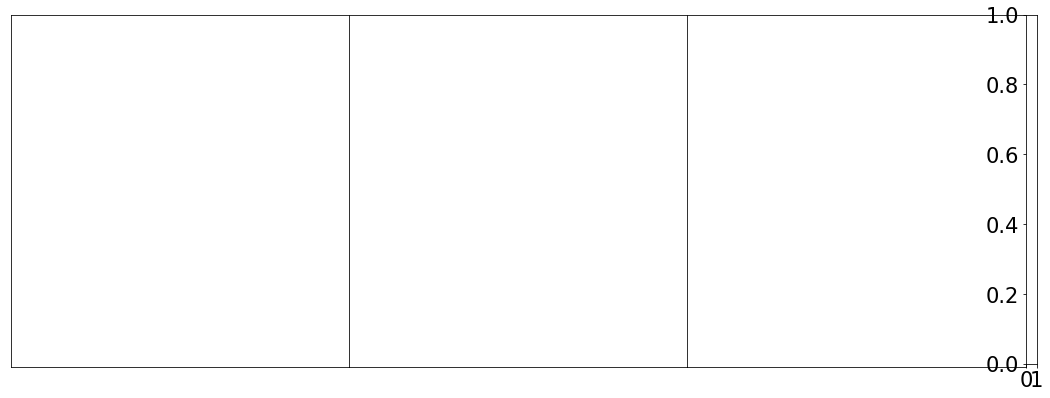

In [7]:
plot_settings()

fs = 5

show_axis = False

temp_labels = {'fiducial':'Fiducial','sn_otrad_no-ion':'No Ionizing Radiation','otrad_ion-no-sn':'Radiation Only'}

def plot_image_panel(time,axis, runs=None):
    nrow,ncol=1,3
    fig, ax = plt.subplots(nrow,ncol, sharex=True, sharey=True)
    fig.set_size_inches(fs*ncol,fs*nrow)
    #fig.subplots_adjust(wspace=0,hspace=0)
    fig.subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.95,
                    wspace=0.0, hspace=0.00)
    #
    # plot many panel phase diagram
    #

    if runs is None:
        runs = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
            'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
            'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn']

    image_type = 'proj'
    xlim = [-2.5,2.5]
    ylim = [2.5, 2.5]
    #phase_type = "nT_phase_outside_disk"


    axi,axj=0,0
    for i,run in enumerate(runs):
        
        if nrow == 1:
            axindex = axj
        else:
            axindex = (axi,axj)


        if show_axis:
            if axi == 2:
                ax[axindex].set_xlabel(r"x (kpc)")
                ax[axindex].set_xticks([-1.0,-0.5,0,0.5,1.0])        
               

            if axj == 0:
                ax[axindex].set_ylabel(r"y (kpc)")
                ax[axindex].set_yticks([-1.0,-0.5,0,0.5,1.0])
             
            else:
                ax[axindex].set_yticks([])
            #ax[axindex].set_yticks([1,2,3,4,5,6,7])
            ax[axindex].set_yticks([-1.0,-0.5,0,0.5,1.0])
        else:
            ax[axindex].set_xticks([])
            ax[axindex].set_yticks([])
           


        # iterate for now to work woth continue
        axj = axj + 1
        if axj >= 3:
            axj = 0
            axi = axi + 1
        xy = (0.025,0.025)
        ax[axindex].annotate( temp_labels[run], xy=xy,xycoords='axes fraction', color='white')
        
        annotate_this_one = False
        if np.size(axindex) > 1:
            if axindex[1] == 2 and axindex[0] == 2:
                annotate_this_one = True
        elif axindex == ncol-1:
            annotate_this_one=True
            
        if annotate_this_one:
            xy = (0.025, 0.925)
            ax[axindex].annotate("250 pc", xy =xy, xycoords='axes fraction', color = 'white')
            shift = 0.1
            ax[axindex].plot([-1.125+shift,-0.875+shift],[0.98,0.98], lw = 4, color = 'white')
            
        annotate_this_one = False
        if np.size(axindex) > 1:
            if axindex[1] == 0 and axindex[0] == 0:
                annotate_this_one = True
        elif axindex == 0:
            annotate_this_one=True
            
        if annotate_this_one:
            
            xy = (0.025, 0.925)
            ax[axindex].annotate("%5.1f Myr"%(time), xy =xy, xycoords='axes fraction', color = 'white')
        #    shift = 0.1
        #    ax[axindex].plot([-1.125+shift,-0.875+shift],[0.98,0.98], lw = 4, color = 'white')
                        
            
            
        image_data = all_data[run].load_image(time, "('gas', 'number_density')",axis, "proj")

        if image_data is None:
            print("Missing data for run ", run)
            continue

        im = ax[axindex].imshow(image_data, cmap = 'viridis', norm = LogNorm(),
                                vmin = 2.0E-4, vmax = 100.0,
                                extent=[-1.25,1.25,-1.25,1.25])
        

                                     #vmin=np.log10(0.01), vmax = np.log10(6.0E4))

        #ax[axindex].annotate(xy,xytext=)
        #ax[axindex].semilogx()
        #ax[axindex].semilogy()
        ax[axindex].set_xlim(-1.25,1.25)
        ax[axindex].set_ylim(-1.25,1.25)
        #ax[axindex].set_ylim(0,7)
        #if axindex[0] == 2:
        #    ax[axindex].xaxis.set_xticks(np.arange(-2.5,3.0,0.5))
        


        if False:
            if axindex[1] == 2:
                divider = make_axes_locatable(ax[axindex])
                cax     = divider.append_axes("right", size="4%", pad=0.0)    


                c = fig.colorbar(im, cax=cax)
                c.set_label(r"Number Density (cm$^{-3}$)")
                

        plt.minorticks_on()
    
    cb_ax = fig.add_axes([0.95, 0.02, 0.01, 0.97])
    cbar = fig.colorbar(im, cax=cb_ax)

 #set the colorbar ticks and tick labels
    #cbar.set_ticks(np.arange(0, 1.1, 0.5))
    cbar.set_label(r"Number Density (cm$^{-3}$)")
    
    
    fig.savefig("proj_panel_2/proj_plot_n_" + axis + "_" + "%03i"%(time) + ".png", bbox_inches="tight")

    plt.close()
    return

runs = None
runs = ['fiducial','sn_otrad_no-ion','otrad_ion-no-sn']
for i in np.arange(0,600,2):# np.arange(0,500,5):
    plot_image_panel(i,'z',runs=runs)
    plot_image_panel(i,'x',runs=runs)

In [40]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison + ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5']
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Mg') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Mg')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Mg')
    M_disk2 = all_data[run].load_field('/gas_meta_data/masses/Disk/Fe')
    
    aratio = convert_abundances.abundance_ratio_array('Mg',M_disk,'Fe',M_disk2,'mass')
    
    ax[0].plot(t, aratio,
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])    

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    M_disk2 = all_data[run].load_field('/gas_meta_data/masses/Disk/Fe')
    
    aratio = convert_abundances.abundance_ratio_array('Ba',M_disk,'Fe',M_disk2,'mass')
    #M_disk[t < 150] = None
    
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])
    
    ax[1].plot(t, aratio,
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(-1, 1) #   'shortrad',
ax[0].set_ylabel(r'[Mg/Fe]')
ax[1].set_ylabel(r'[Ba/Fe]')

#ax.semilogy()

M_disk = all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Mg')+all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Mg')
M_disk2 = np.ones(np.size(M_disk))*all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/H')[0]
    
aratio = convert_abundances.abundance_ratio_array('Mg',M_disk,'H',M_disk2,'mass')
t   = all_data['fiducial'].data('time')
t = t - t[0]   
print(np.max(aratio))
#ax[0].plot(t, aratio, ls = '--',
#            lw = 5, color = 'black')

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_gas_abundance.png")

<ipython-input-40-eaef146d7365>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2)


0.054732847759715965
0.31228265739808614
-1.931763869487206


In [427]:
temp = all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/')

In [434]:
convert_abundances.abundance_ratio_array?